# 🗞️ OLJ Customer Segmentation Heuristics 8-Week Rolling Data Analysis & Temperature Change Script

<img src="https://media.istockphoto.com/id/1298101277/vector/digital-marketing-online-advertising-smm-app-notification-chatting-viral-content-internet.jpg?s=612x612&w=0&k=20&c=4wlS9BCPb6VIo7CrIjTqddfKaNfaUUnlFjt25K7U8fk=" alt="Bike Store" width="200" align="right">

    This script relies on 2 Matomo Reports:

    1. User Engagement Rules
    2. User Cadency Report

    AND List of Current Subscribers (exported from the CMS)
    AND List of New Accounts in this month & the past month (exported from the CMS)


# A. Getting the Data Ready

**I. Goal: Make an Engagement Data Frame**

1. Clean messy Excel files into structured columns with readable durations.

In [1]:
# Clean User Engagement Report (exact columns + pretty durations) → save in /content/cleaned

import os
import re
import math
import pandas as pd
from google.colab import files
from datetime import date
from IPython.display import display

# ---------- Safe base and output directory ----------
BASE_DIR = "/content" if os.path.isdir("/content") else os.getcwd()
CLEAN_DIR = os.path.join(BASE_DIR, "cleaned")
os.makedirs(CLEAN_DIR, exist_ok=True)
print("Saving outputs to:", CLEAN_DIR)

# ---------- Upload files ----------
uploaded = files.upload()   # multi-select ok
names = sorted(uploaded.keys())
today = date.today().isoformat()

# ---------- Helpers ----------
def read_csv_robust(path):
    """Try utf-8-sig, then utf-16; if still 1 col, manual 'quoted line' split."""
    last_err = None
    for enc in ("utf-8-sig", "utf-16"):
        try:
            tmp = pd.read_csv(path, encoding=enc, sep=",", engine="python")
            if tmp.shape[1] > 1:
                return tmp
        except Exception as e:
            last_err = e
    # Manual fallback for all-in-one quoted column
    with open(path, "r", encoding="utf-8-sig", errors="replace") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    if not lines:
        raise ValueError(f"Empty file: {path} (last pandas error: {last_err})")
    rows = []
    for ln in lines:
        if ln.startswith('"') and ln.endswith('"'):
            ln = ln[1:-1]
        rows.append(ln.split(","))
    header = [h.strip().strip('"').replace("\ufeff","") for h in rows[0]]
    data = rows[1:]
    return pd.DataFrame(data, columns=header)

def seconds_to_hr_min(seconds):
    try:
        seconds = float(seconds)
        if math.isnan(seconds):
            return ""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        return f"{hours} hr {minutes} min"
    except Exception:
        return ""

def safe_slug(name: str) -> str:
    base = os.path.basename(name)
    base = os.path.splitext(base)[0]
    base = re.sub(r"[^\w\-]+", "_", base).strip("_")
    return base or "report"

# ---------- Exact renames you requested ----------
RENAME_MAP = {
    "Label": "UserId",
    "sum_actions": "Total Actions",
    "sum_corehome_visittotaltime": "Visit Total Time (seconds)",
}

# Columns we keep (after renaming)
KEEP_COLS = [
    "UserId",
    "Total Actions",
    "Visits",
    "Visit Total Time (seconds)",
    "Avg. Actions In Visit per Visit",
    "Avg. Visit Duration (in seconds) per Visit",
]

# Noise columns to drop if present
DROP_COLS = {"level", "Metadata: segment"}

for idx, SRC in enumerate(names, start=1):
    print(f"\nProcessing {SRC} as week{idx}...")
    try:
        df = read_csv_robust(SRC)

        # (1) Rename exactly as specified (only if present)
        present_renames = {k: v for k, v in RENAME_MAP.items() if k in df.columns}
        df = df.rename(columns=present_renames)

        # (2) Drop noise columns if present
        drop_now = [c for c in df.columns if c in DROP_COLS]
        if drop_now:
            df = df.drop(columns=drop_now, errors="ignore")

        # (3) Keep only the requested columns that actually exist
        keep_now = [c for c in KEEP_COLS if c in df.columns]
        df = df[keep_now].copy()

        # (4) Normalize dtypes
        if "UserId" in df.columns:
            df["UserId"] = pd.to_numeric(df["UserId"], errors="coerce").astype("Int64")
            df = df.dropna(subset=["UserId"]).copy()

        numeric_cols = [
            c for c in ["Total Actions", "Visits",
                        "Visit Total Time (seconds)",
                        "Avg. Actions In Visit per Visit",
                        "Avg. Visit Duration (in seconds) per Visit"]
            if c in df.columns
        ]
        for c in numeric_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")

        # (5) Pretty duration columns
        if "Visit Total Time (seconds)" in df.columns:
            df["Visit Total Time (hr/min)"] = df["Visit Total Time (seconds)"].apply(seconds_to_hr_min)

        if "Avg. Visit Duration (in seconds) per Visit" in df.columns:
            df["Avg. Visit Duration per Visit (hr/min)"] = df["Avg. Visit Duration (in seconds) per Visit"].apply(seconds_to_hr_min)

        # (6) Order columns nicely
        ordered = [
            "UserId",
            "Total Actions",
            "Visits",
            "Visit Total Time (seconds)",
            "Visit Total Time (hr/min)",
            "Avg. Actions In Visit per Visit",
            "Avg. Visit Duration (in seconds) per Visit",
            "Avg. Visit Duration per Visit (hr/min)",
        ]
        df = df[[c for c in ordered if c in df.columns]]

        # (7) Save & auto-download
        out_xlsx = os.path.join(CLEAN_DIR, f"user_engagement_clean_week{idx}_{today}.xlsx")
        df.to_excel(out_xlsx, index=False)
        files.download(out_xlsx)

        print(f"  ✓ Saved {len(df):,} rows → {out_xlsx}")
        display(df.head(20))

    except Exception as e:
        print(f"  ✗ Skipped {SRC} (week{idx}) due to {type(e).__name__}: {e}")
        continue



Saving outputs to: /content/cleaned


Saving Aug4-Aug10.csv to Aug4-Aug10.csv
Saving Aug11-Aug17.csv to Aug11-Aug17.csv
Saving Aug18-Aug24.csv to Aug18-Aug24.csv
Saving Aug25-Aug31.csv to Aug25-Aug31.csv
Saving Jul14-Jul20.csv to Jul14-Jul20.csv
Saving Jul21-Jul27.csv to Jul21-Jul27.csv
Saving Jul28-Aug3.csv to Jul28-Aug3.csv
Saving Sep1-Sep7.csv to Sep1-Sep7.csv

Processing Aug11-Aug17.csv as week1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week1_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,435770,3370,302,277926,77 hr 12 min,11.16,920.28,0 hr 15 min
1,502191,734,108,25738,7 hr 8 min,6.80,238.31,0 hr 3 min
2,465820,555,107,36417,10 hr 6 min,5.19,340.35,0 hr 5 min
3,13479,655,99,132368,36 hr 46 min,6.62,1337.05,0 hr 22 min
4,9405,1556,96,95126,26 hr 25 min,16.21,990.90,0 hr 16 min
5,6874,760,91,107249,29 hr 47 min,8.35,1178.56,0 hr 19 min
6,469537,1034,91,128715,35 hr 45 min,11.36,1414.45,0 hr 23 min
7,537438,696,90,50894,14 hr 8 min,7.73,565.49,0 hr 9 min
8,462266,281,89,52222,14 hr 30 min,3.16,586.76,0 hr 9 min
9,17834,798,87,63847,17 hr 44 min,9.17,733.87,0 hr 12 min



Processing Aug18-Aug24.csv as week2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week2_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,435770,3587,289,361481,100 hr 24 min,12.41,1250.80,0 hr 20 min
1,0,1225,224,44634,12 hr 23 min,5.47,199.26,0 hr 3 min
2,459104,2702,93,223408,62 hr 3 min,29.05,2402.24,0 hr 40 min
3,473566,1695,89,130856,36 hr 20 min,19.04,1470.29,0 hr 24 min
4,9405,1577,87,97120,26 hr 58 min,18.13,1116.32,0 hr 18 min
5,6329,1953,86,132650,36 hr 50 min,22.71,1542.44,0 hr 25 min
6,11325,624,86,108585,30 hr 9 min,7.26,1262.62,0 hr 21 min
7,19327,891,86,68674,19 hr 4 min,10.36,798.53,0 hr 13 min
8,485833,1041,86,159041,44 hr 10 min,12.10,1849.31,0 hr 30 min
9,27355,879,84,70426,19 hr 33 min,10.46,838.40,0 hr 13 min



Processing Aug25-Aug31.csv as week3...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week3_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,0,1782,652,30844,8 hr 34 min,2.73,47.31,0 hr 0 min
1,435770,4004,333,448161,124 hr 29 min,12.02,1345.83,0 hr 22 min
2,29251,1551,141,260485,72 hr 21 min,11.00,1847.41,0 hr 30 min
3,469537,972,100,93774,26 hr 2 min,9.72,937.74,0 hr 15 min
4,434677,1583,92,171309,47 hr 35 min,17.21,1862.05,0 hr 31 min
5,502191,891,88,36119,10 hr 1 min,10.13,410.44,0 hr 6 min
6,6412,1267,87,69025,19 hr 10 min,14.56,793.39,0 hr 13 min
7,473566,1566,87,119309,33 hr 8 min,18.00,1371.37,0 hr 22 min
8,8627,672,85,43241,12 hr 0 min,7.91,508.72,0 hr 8 min
9,22157,984,84,55827,15 hr 30 min,11.71,664.61,0 hr 11 min



Processing Aug4-Aug10.csv as week4...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week4_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,435770,2954,281,226777,62 hr 59 min,10.51,807.04,0 hr 13 min
1,559303,382,161,66307,18 hr 25 min,2.37,411.84,0 hr 6 min
2,502191,1135,127,51706,14 hr 21 min,8.94,407.13,0 hr 6 min
3,226298,2652,97,158963,44 hr 9 min,27.34,1638.79,0 hr 27 min
4,8627,705,94,47068,13 hr 4 min,7.50,500.72,0 hr 8 min
5,9405,1433,90,127499,35 hr 24 min,15.92,1416.66,0 hr 23 min
6,23805,326,90,1298,0 hr 21 min,3.62,14.42,0 hr 0 min
7,29251,1748,90,326523,90 hr 42 min,19.42,3628.03,1 hr 0 min
8,6412,1482,89,109139,30 hr 18 min,16.65,1226.28,0 hr 20 min
9,469537,1020,89,128230,35 hr 37 min,11.46,1440.79,0 hr 24 min



Processing Jul14-Jul20.csv as week5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week5_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,435770,4378,366,365596,101 hr 33 min,11.96,998.90,0 hr 16 min
1,559303,779,327,141293,39 hr 14 min,2.38,432.09,0 hr 7 min
2,533920,555,106,212241,58 hr 57 min,5.24,2002.27,0 hr 33 min
3,479129,274,99,15140,4 hr 12 min,2.77,152.93,0 hr 2 min
4,473566,1191,97,71696,19 hr 54 min,12.28,739.13,0 hr 12 min
5,17834,845,94,65529,18 hr 12 min,8.99,697.12,0 hr 11 min
6,480385,1216,92,123318,34 hr 15 min,13.22,1340.41,0 hr 22 min
7,6329,2138,91,153042,42 hr 30 min,23.49,1681.78,0 hr 28 min
8,6352,1449,90,141018,39 hr 10 min,16.10,1566.87,0 hr 26 min
9,226298,2116,88,158687,44 hr 4 min,24.05,1803.26,0 hr 30 min



Processing Jul21-Jul27.csv as week6...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week6_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,435770,3931,324,374622,104 hr 3 min,12.13,1156.24,0 hr 19 min
1,559303,771,322,139948,38 hr 52 min,2.39,434.62,0 hr 7 min
2,469537,768,94,88294,24 hr 31 min,8.17,939.30,0 hr 15 min
3,7223,1223,93,81070,22 hr 31 min,13.15,871.72,0 hr 14 min
4,473566,1100,93,76964,21 hr 22 min,11.83,827.57,0 hr 13 min
5,6295,491,91,54234,15 hr 3 min,5.40,595.98,0 hr 9 min
6,34257,761,88,45028,12 hr 30 min,8.65,511.68,0 hr 8 min
7,460718,359,88,42291,11 hr 44 min,4.08,480.58,0 hr 8 min
8,537438,897,86,70175,19 hr 29 min,10.43,815.99,0 hr 13 min
9,459104,2036,84,180975,50 hr 16 min,24.24,2154.46,0 hr 35 min



Processing Jul28-Aug3.csv as week7...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week7_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,435770,3863,360,305109,84 hr 45 min,10.73,847.53,0 hr 14 min
1,559303,784,322,139568,38 hr 46 min,2.43,433.44,0 hr 7 min
2,9405,1279,103,85624,23 hr 47 min,12.42,831.30,0 hr 13 min
3,469537,883,92,103629,28 hr 47 min,9.60,1126.40,0 hr 18 min
4,436486,949,86,56226,15 hr 37 min,11.03,653.79,0 hr 10 min
5,226298,1664,83,94518,26 hr 15 min,20.05,1138.77,0 hr 18 min
6,502191,726,81,31300,8 hr 41 min,8.96,386.42,0 hr 6 min
7,537438,779,80,84431,23 hr 27 min,9.74,1055.39,0 hr 17 min
8,6352,1421,79,157769,43 hr 49 min,17.99,1997.08,0 hr 33 min
9,6412,1248,79,104189,28 hr 56 min,15.80,1318.85,0 hr 21 min



Processing Sep1-Sep7.csv as week8...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_engagement_clean_week8_2025-10-07.xlsx


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min)
0,435770,3791,312,480399,133 hr 26 min,12.15,1539.74,0 hr 25 min
1,0,1001,238,18792,5 hr 13 min,4.21,78.96,0 hr 1 min
2,469537,950,98,101017,28 hr 3 min,9.69,1030.79,0 hr 17 min
3,10323,877,89,97146,26 hr 59 min,9.85,1091.53,0 hr 18 min
4,34257,797,89,43717,12 hr 8 min,8.96,491.20,0 hr 8 min
5,226091,843,88,65344,18 hr 9 min,9.58,742.55,0 hr 12 min
6,7223,1193,86,55225,15 hr 20 min,13.87,642.15,0 hr 10 min
7,473566,1307,86,95013,26 hr 23 min,15.20,1104.80,0 hr 18 min
8,517656,554,86,67691,18 hr 48 min,6.44,787.10,0 hr 13 min
9,17834,807,85,80683,22 hr 24 min,9.49,949.21,0 hr 15 min


2. Stacks all cleaned weekly engagement files so each row represents a user’s activity for one week, adding a WeeksActive column showing how many weeks each user appeared.

In [2]:
import os, glob, re
import pandas as pd

CLEAN_DIR = "/content/cleaned"

# Find new engagement files first; fall back to the older category-split pattern
pat_xlsx_new = os.path.join(CLEAN_DIR, "user_engagement_clean_week*_*.xlsx")
pat_csv_new  = os.path.join(CLEAN_DIR, "user_engagement_clean_week*_*.csv")

pat_xlsx_old = os.path.join(CLEAN_DIR, "user_category_split_report_week*_*.xlsx")
pat_csv_old  = os.path.join(CLEAN_DIR, "user_category_split_report_week*_*.csv")

def sort_by_week(files):
    def wknum(f):
        m = re.search(r"week(\d+)", os.path.basename(f))
        return int(m.group(1)) if m else 0
    return sorted(files, key=wknum)

xlsx_files = sort_by_week(glob.glob(pat_xlsx_new) or glob.glob(pat_xlsx_old))
csv_files  = sort_by_week(glob.glob(pat_csv_new)  or glob.glob(pat_csv_old))

files = xlsx_files if xlsx_files else csv_files
if not files:
    raise FileNotFoundError(
        "No cleaned exports found in /content/cleaned. "
        "Expected files like 'user_engagement_clean_weekN_YYYY-MM-DD.xlsx'."
    )

dfs = []
for f in files:
    # Extract the week number from the filename
    m = re.search(r"week(\d+)", os.path.basename(f))
    week_num = int(m.group(1)) if m else None

    # Read Excel or CSV
    df_week = pd.read_excel(f) if f.lower().endswith(".xlsx") else pd.read_csv(f)

    # Ensure numeric UserId (nullable Int64). Engagement reports have no CategoryId.
    if "UserId" in df_week.columns:
        df_week["UserId"] = pd.to_numeric(df_week["UserId"], errors="coerce").astype("Int64")

    # Tag week from filename
    if week_num is not None:
        df_week["Week"] = week_num

    dfs.append(df_week)

# Combine all weeks
all_weeks_df = pd.concat(dfs, ignore_index=True)

# Count distinct weeks per user
user_weeks_active = (
    all_weeks_df[["UserId", "Week"]]
    .dropna(subset=["UserId", "Week"])
    .drop_duplicates()
    .groupby("UserId", as_index=False)["Week"]
    .nunique()
    .rename(columns={"Week": "WeeksActive"})
)

# Make WeeksActive nullable Int64 (no floats, keeps NA if any)
user_weeks_active["WeeksActive"] = user_weeks_active["WeeksActive"].astype("Int64")

# Merge back
all_weeks_df = all_weeks_df.merge(user_weeks_active, on="UserId", how="left")

# Quick preview with Week + WeeksActive highlighted
styled = (
    all_weeks_df.head(20)
    .style
    .apply(
        lambda row: [
            'background-color: lightyellow' if col in ["Week", "WeeksActive"] else ''
            for col in row.index
        ],
        axis=1
    )
)
styled


,UserId,Total Actions,Visits,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min),Week,WeeksActive
0,435770,3370,302,277926,77 hr 12 min,11.160000,920.280000,0 hr 15 min,1,8
1,502191,734,108,25738,7 hr 8 min,6.800000,238.310000,0 hr 3 min,1,8
2,465820,555,107,36417,10 hr 6 min,5.190000,340.350000,0 hr 5 min,1,8
3,13479,655,99,132368,36 hr 46 min,6.620000,1337.050000,0 hr 22 min,1,8
4,9405,1556,96,95126,26 hr 25 min,16.210000,990.900000,0 hr 16 min,1,8
5,6874,760,91,107249,29 hr 47 min,8.350000,1178.560000,0 hr 19 min,1,8
6,469537,1034,91,128715,35 hr 45 min,11.360000,1414.450000,0 hr 23 min,1,8
7,537438,696,90,50894,14 hr 8 min,7.730000,565.490000,0 hr 9 min,1,8
8,462266,281,89,52222,14 hr 30 min,3.160000,586.760000,0 hr 9 min,1,8
9,17834,798,87,63847,17 hr 44 min,9.170000,733.870000,0 hr 12 min,1,8


**II. Goal: Make a Cadence Data Frame**

1. Clean messy Excel files into structured columns with readable durations.

In [3]:
# Clean User Cadence Reports (handles UTF-16 TSV + control chars)
import os, re, io
import pandas as pd
from google.colab import files
from datetime import date
from IPython.display import display

# ---------- Output dir ----------
BASE_DIR = "/content" if os.path.isdir("/content") else os.getcwd()
CLEAN_DIR = os.path.join(BASE_DIR, "cleaned")
os.makedirs(CLEAN_DIR, exist_ok=True)
print("Saving outputs to:", CLEAN_DIR)

uploaded = files.upload()           # multi-select OK
names = sorted(uploaded.keys())
today = date.today().isoformat()

# ---------- Helpers ----------
CONTROL_CHARS_RE = re.compile(r"[\x00-\x08\x0B-\x0C\x0E-\x1F]")

def strip_control_chars_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [CONTROL_CHARS_RE.sub("", str(c)) for c in df.columns]
    for c in df.columns:
        if pd.api.types.is_string_dtype(df[c]) or df[c].dtype == "object":
            df[c] = df[c].astype(str).map(lambda s: CONTROL_CHARS_RE.sub("", s))
    return df

def read_csv_robust(path):
    # 1) UTF-16 TSV
    try:
        df = pd.read_csv(path, encoding="utf-16", sep="\t", engine="python")
        if df.shape[1] > 1:
            return df
    except Exception:
        pass
    # 2) UTF-16 CSV
    try:
        df = pd.read_csv(path, encoding="utf-16", sep=",", engine="python")
        if df.shape[1] > 1:
            return df
    except Exception:
        pass
    # 3) UTF-8-SIG TSV
    try:
        df = pd.read_csv(path, encoding="utf-8-sig", sep="\t", engine="python")
        if df.shape[1] > 1:
            return df
    except Exception:
        pass
    # 4) UTF-8-SIG CSV
    return pd.read_csv(path, encoding="utf-8-sig", sep=",", engine="python")

def norm(s: str) -> str:
    s = str(s).replace("\xa0", " ")
    s = " ".join(s.strip().split())
    return s

# Canonical names (exact casing we want)
KEEP_ORDER = [
    "UserId",
    "Visits",                                  # <-- added
    "Total Days since last visit",
    "Max Days since last visit",
    "Avg. Days since last visit per Visit",
]

DROP_NORMALIZED = {
    "level",
    "metadata: segment",
    "metadata:: segment",
    "metadata::segment",
    "metadata:segment",
}

for idx, src in enumerate(names, start=1):
    print(f"\nProcessing {src} as week{idx}...")
    try:
        df = read_csv_robust(src)
        df = strip_control_chars_df(df)

        # --- normalize headers (trim/collapse spaces) ---
        col_map = {c: norm(c) for c in df.columns}

        # map to canonical
        rename = {}
        for c, n in col_map.items():
            low = n.lower()
            if low == "label":
                rename[c] = "UserId"
            elif low == "visits":
                rename[c] = "Visits"
            elif low == "total days since last visit":
                rename[c] = "Total Days since last visit"
            elif low == "max days since last visit":
                rename[c] = "Max Days since last visit"
            elif low == "avg. days since last visit per visit":
                rename[c] = "Avg. Days since last visit per Visit"

        if rename:
            df = df.rename(columns=rename)

        # drop noise columns by normalized name
        to_drop = [c for c in df.columns if norm(c).lower() in DROP_NORMALIZED]
        if to_drop:
            df = df.drop(columns=to_drop, errors="ignore")

        # keep only required columns that exist
        keep_now = [c for c in KEEP_ORDER if c in df.columns]
        if not keep_now:
            print("⚠️ Expected cadence columns not found after normalization; keeping all for inspection.")
            print("Columns:", list(df.columns))
            keep_now = list(df.columns)
        df = df[keep_now].copy()

        # dtypes: UserId as nullable Int64 if mostly numeric, else keep as string
        if "UserId" in df.columns:
            tmp = pd.to_numeric(df["UserId"], errors="coerce")
            nonnull = df["UserId"].notna().sum()
            numeric = tmp.notna().sum()
            if nonnull > 0 and numeric / max(nonnull, 1) >= 0.8:
                df["UserId"] = tmp.astype("Int64")
                df = df.dropna(subset=["UserId"]).copy()
            else:
                df["UserId"] = df["UserId"].astype(str).str.strip()

        # metrics to numeric when present (✅ fixed missing comma)
        for c in [
            "Visits",
            "Total Days since last visit",
            "Max Days since last visit",
            "Avg. Days since last visit per Visit",
        ]:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")

        # final column order
        ordered = [c for c in KEEP_ORDER if c in df.columns]
        if ordered:
            df = df[ordered]

        out_xlsx = os.path.join(CLEAN_DIR, f"user_cadence_clean_week{idx}_{today}.xlsx")
        df.to_excel(out_xlsx, index=False)
        files.download(out_xlsx)

        print(f"  ✓ Saved {len(df):,} rows → {out_xlsx}")
        display(df.head(20))

    except Exception as e:
        print(f"  ✗ Skipped {src} (week{idx}) due to {type(e).__name__}: {e}")


Saving outputs to: /content/cleaned


Saving Export _ User Cadence Report _ week August 4 – 10, 2025.csv to Export _ User Cadence Report _ week August 4 – 10, 2025.csv
Saving Export _ User Cadence Report _ week August 11 – 17, 2025.csv to Export _ User Cadence Report _ week August 11 – 17, 2025.csv
Saving Export _ User Cadence Report _ week August 18 – 24, 2025.csv to Export _ User Cadence Report _ week August 18 – 24, 2025.csv
Saving Export _ User Cadence Report _ week August 25 – 31, 2025.csv to Export _ User Cadence Report _ week August 25 – 31, 2025.csv
Saving Export _ User Cadence Report _ week July 14 – 20, 2025.csv to Export _ User Cadence Report _ week July 14 – 20, 2025.csv
Saving Export _ User Cadence Report _ week July 21 – 27, 2025.csv to Export _ User Cadence Report _ week July 21 – 27, 2025.csv
Saving Export _ User Cadence Report _ week July 28 – August 3, 2025.csv to Export _ User Cadence Report _ week July 28 – August 3, 2025.csv
Saving Export _ User Cadence Report _ week September 1 – 7, 2025.csv to Export

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week1_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,435770,302,0,0,0.00
1,502191,108,0,0,0.00
2,465820,107,0,0,0.00
3,13479,99,2,1,0.02
4,9405,96,0,0,0.00
5,6874,91,0,0,0.00
6,469537,91,0,0,0.00
7,537438,90,0,0,0.00
8,462266,89,0,0,0.00
9,17834,87,0,0,0.00



Processing Export _ User Cadence Report _ week August 18 – 24, 2025.csv as week2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week2_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,435770,289,26,1,0.09
1,0,224,271,64,1.21
2,459104,93,0,0,0.00
3,473566,89,0,0,0.00
4,9405,87,0,0,0.00
5,6329,86,0,0,0.00
6,11325,86,0,0,0.00
7,19327,86,0,0,0.00
8,485833,86,0,0,0.00
9,27355,84,0,0,0.00



Processing Export _ User Cadence Report _ week August 25 – 31, 2025.csv as week3...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week3_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,0,652,346,319,0.53
1,435770,333,0,0,0.00
2,29251,141,0,0,0.00
3,469537,100,0,0,0.00
4,434677,92,0,0,0.00
5,502191,88,0,0,0.00
6,6412,87,0,0,0.00
7,473566,87,0,0,0.00
8,8627,85,0,0,0.00
9,22157,84,0,0,0.00



Processing Export _ User Cadence Report _ week August 4 – 10, 2025.csv as week4...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week4_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,435770,281,0,0,0.0
1,559303,161,0,0,0.0
2,502191,127,0,0,0.0
3,226298,97,0,0,0.0
4,8627,94,0,0,0.0
5,9405,90,0,0,0.0
6,23805,90,0,0,0.0
7,29251,90,0,0,0.0
8,6412,89,0,0,0.0
9,469537,89,0,0,0.0



Processing Export _ User Cadence Report _ week July 14 – 20, 2025.csv as week5...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week5_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,435770,366,0,0,0.00
1,559303,327,0,0,0.00
2,533920,106,9,9,0.08
3,479129,99,1,1,0.01
4,473566,97,0,0,0.00
5,17834,94,0,0,0.00
6,480385,92,0,0,0.00
7,6329,91,0,0,0.00
8,6352,90,0,0,0.00
9,226298,88,0,0,0.00



Processing Export _ User Cadence Report _ week July 21 – 27, 2025.csv as week6...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week6_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,435770,324,0,0,0.0
1,559303,322,0,0,0.0
2,469537,94,0,0,0.0
3,7223,93,0,0,0.0
4,473566,93,0,0,0.0
5,6295,91,0,0,0.0
6,34257,88,0,0,0.0
7,460718,88,0,0,0.0
8,537438,86,0,0,0.0
9,459104,84,0,0,0.0



Processing Export _ User Cadence Report _ week July 28 – August 3, 2025.csv as week7...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week7_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,435770,360,0,0,0.0
1,559303,322,0,0,0.0
2,9405,103,0,0,0.0
3,469537,92,0,0,0.0
4,436486,86,0,0,0.0
5,226298,83,0,0,0.0
6,502191,81,0,0,0.0
7,537438,80,0,0,0.0
8,6352,79,0,0,0.0
9,6412,79,0,0,0.0



Processing Export _ User Cadence Report _ week September 1 – 7, 2025.csv as week8...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Saved 9,998 rows → /content/cleaned/user_cadence_clean_week8_2025-10-07.xlsx


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit
0,435770,312,0,0,0.00
1,0,238,80,43,0.34
2,469537,98,0,0,0.00
3,10323,89,0,0,0.00
4,34257,89,0,0,0.00
5,226091,88,0,0,0.00
6,7223,86,0,0,0.00
7,473566,86,0,0,0.00
8,517656,86,0,0,0.00
9,17834,85,0,0,0.00


2. Stacks all weekly cadence files vertically so each row represents a user’s activity for one week, adding a WeeksActive column showing how many weeks each user appeared.

In [4]:
# Combine cleaned CADENCE files → all_weeks_df_cadence
import os, glob, re
import pandas as pd

CLEAN_DIR = "/content/cleaned"

# Look for cleaned CADENCE files only
pat_xlsx_cad = os.path.join(CLEAN_DIR, "user_cadence_clean_week*_*.xlsx")
pat_csv_cad  = os.path.join(CLEAN_DIR, "user_cadence_clean_week*_*.csv")

def sort_by_week(files):
    def wknum(f):
        m = re.search(r"week(\d+)", os.path.basename(f))
        return int(m.group(1)) if m else 0
    return sorted(files, key=wknum)

xlsx_files_cad = sort_by_week(glob.glob(pat_xlsx_cad))
csv_files_cad  = sort_by_week(glob.glob(pat_csv_cad))

files_cad = xlsx_files_cad if xlsx_files_cad else csv_files_cad
if not files_cad:
    raise FileNotFoundError(
        "No cleaned cadence exports found in /content/cleaned. "
        "Expected files like 'user_cadence_clean_weekN_YYYY-MM-DD.xlsx'."
    )

dfs_cadence = []
for f in files_cad:
    # Extract the week number from the filename
    m = re.search(r"week(\d+)", os.path.basename(f))
    week_num = int(m.group(1)) if m else None

    # Read Excel or CSV
    df_week_cad = pd.read_excel(f) if f.lower().endswith(".xlsx") else pd.read_csv(f)

    # Ensure numeric UserId (nullable Int64)
    if "UserId" in df_week_cad.columns:
        df_week_cad["UserId"] = pd.to_numeric(df_week_cad["UserId"], errors="coerce").astype("Int64")

    # Tag Week from filename
    if week_num is not None:
        df_week_cad["Week"] = week_num

    dfs_cadence.append(df_week_cad)

# Combine all cadence weeks
all_weeks_df_cadence = pd.concat(dfs_cadence, ignore_index=True)

# Count distinct weeks per user (cadence)
user_weeks_active_cadence = (
    all_weeks_df_cadence[["UserId", "Week"]]
    .dropna(subset=["UserId", "Week"])
    .drop_duplicates()
    .groupby("UserId", as_index=False)["Week"]
    .nunique()
    .rename(columns={"Week": "WeeksActive"})
)

# Keep nullable Int64
user_weeks_active_cadence["WeeksActive"] = user_weeks_active_cadence["WeeksActive"].astype("Int64")

# Merge back
all_weeks_df_cadence = all_weeks_df_cadence.merge(user_weeks_active_cadence, on="UserId", how="left")

# Quick preview with Week + WeeksActive highlighted
styled_cadence = (
    all_weeks_df_cadence.head(20)
    .style
    .apply(
        lambda row: [
            'background-color: lightyellow' if col in ["Week", "WeeksActive"] else ''
            for col in row.index
        ],
        axis=1
    )
)
styled_cadence


,UserId,Visits,Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit,Week,WeeksActive
0,435770,302,0,0,0.000000,1,8
1,502191,108,0,0,0.000000,1,8
2,465820,107,0,0,0.000000,1,8
3,13479,99,2,1,0.020000,1,8
4,9405,96,0,0,0.000000,1,8
5,6874,91,0,0,0.000000,1,8
6,469537,91,0,0,0.000000,1,8
7,537438,90,0,0,0.000000,1,8
8,462266,89,0,0,0.000000,1,8
9,17834,87,0,0,0.000000,1,8


**III. Goal: Merge Engagement and Cadence Data Frames into 'merged'  Data Frame**

In [5]:
import pandas as pd

eng = all_weeks_df.copy()
cad = all_weeks_df_cadence.copy()

# Choose keys
join_keys = ["UserId", "Week"] if ("Week" in eng.columns and "Week" in cad.columns) else ["UserId"]

# Full OUTER join
merged = eng.merge(
    cad,
    on=join_keys,
    how="outer",
    suffixes=("_eng", "_cad")
)

# Coalesce duplicate columns (those present in both, excluding join keys)
dup_bases = []
for c in merged.columns:
    if c.endswith("_eng"):
        base = c[:-4]
        if f"{base}_cad" in merged.columns and base not in join_keys:
            dup_bases.append(base)

for base in dup_bases:
    le, rc = f"{base}_eng", f"{base}_cad"
    if base == "WeeksActive":
        # take the max across sources
        merged[base] = merged[[le, rc]].max(axis=1)
    else:
        # prefer engagement, fallback to cadence
        merged[base] = merged[le].combine_first(merged[rc])
    merged.drop(columns=[le, rc], inplace=True)

# Optional: enforce nullable Int64 where appropriate
for col in ["UserId", "Week", "WeeksActive", "Visits"]:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce").astype("Int64")

# Nice column order: keys first
key_cols = [k for k in join_keys if k in merged.columns]
other_cols = [c for c in merged.columns if c not in key_cols]
merged = merged[key_cols + other_cols]

merged.head(20)

merged.to_excel("/content/merged_engagement_cadence.xlsx", index=False)


**IV. Add Subscribed & New Accounts Layers**

1. Add a *Subscribed* column that flags accounts as 'Subscribed' or 'Not Subscribed' depending on whether they're found in the Current Subscribers sheet (exported from the CMS).

In [6]:
# Add "Subscribed" flag to merged by uploading Current Subscribers, highlight & export

# (Optional) Ensure Excel writer is available in Colab/Jupyter:
# If you're in Colab, this line will install xlsxwriter; harmless elsewhere.
!pip install -q xlsxwriter

import io, re, os, sys
import pandas as pd

# Detect Colab for upload flow
try:
    from google.colab import files  # type: ignore
    _IN_COLAB = True
except Exception:
    _IN_COLAB = False

# ---------- Helpers ----------
def soft_read_any(path_or_bytes):
    """Read Excel/CSV/TSV from path or bytes, trying Excel -> CSV -> TSV."""
    if isinstance(path_or_bytes, (bytes, bytearray)):
        buf = io.BytesIO(path_or_bytes)
        for reader in (pd.read_excel, pd.read_csv):
            try:
                buf.seek(0)
                return reader(buf)
            except Exception:
                pass
        buf.seek(0)
        return pd.read_csv(buf, sep="\t")

    p = str(path_or_bytes)
    pl = p.lower()
    if pl.endswith((".xlsx", ".xls")):
        return pd.read_excel(p)
    if pl.endswith(".tsv"):
        return pd.read_csv(p, sep="\t")
    return pd.read_csv(p)

def find_user_col(cols):
    """Find a UserId-like column by exacts first, then fuzzy."""
    exacts = ["UserId","user_id","userid","uid","id","User ID","userId"]
    for c in exacts:
        if c in cols:
            return c
    for c in cols:
        if re.search(r'user\s*id', str(c), flags=re.I):
            return c
    return None

def excel_col_letter(idx_zero_based: int) -> str:
    """Convert 0-based column index to Excel column letter(s)."""
    n = idx_zero_based + 1
    letters = []
    while n > 0:
        n, rem = divmod(n - 1, 26)
        letters.append(chr(ord('A') + rem))
    return "".join(reversed(letters))

# ---------- 1) Load subscribers file (Excel/CSV/TSV) ----------
if _IN_COLAB:
    print("Upload your CURRENT SUBSCRIBERS file (Excel/CSV/TSV).")
    up = files.upload()  # you can multi-select; we'll use the first
    if not up:
        raise RuntimeError("No file uploaded.")
    sub_name, sub_bytes = next(iter(up.items()))
    subs_df = soft_read_any(sub_bytes)
    print(f"Loaded subscribers: {sub_name} ({len(subs_df):,} rows)")
else:
    # Not in Colab? Set a local path here:
    SUBSCRIBERS_PATH = "./current_subscribers.xlsx"  # change if needed
    if not os.path.exists(SUBSCRIBERS_PATH):
        raise FileNotFoundError(
            "Set SUBSCRIBERS_PATH to your subscribers file path (Excel/CSV/TSV)."
        )
    subs_df = soft_read_any(SUBSCRIBERS_PATH)
    print(f"Loaded subscribers: {SUBSCRIBERS_PATH} ({len(subs_df):,} rows)")

# ---------- 2) Normalize UserId and build a lookup set ----------
uid_col = find_user_col(list(subs_df.columns))
if uid_col is None:
    raise KeyError("Could not detect a UserId-like column in the subscribers file.")
if uid_col != "UserId":
    subs_df = subs_df.rename(columns={uid_col: "UserId"})

# Drop NaNs BEFORE astype(str) to avoid 'nan' strings
subs_ids = set(subs_df["UserId"].dropna().astype(str))

# ---------- 3) Add Subscribed flag to 'merged' ----------
if "merged" not in globals():
    raise RuntimeError("`merged` dataframe not found. Run the merge cell first.")

# Ensure merged has a UserId column (rename if necessary)
m_uid_col = find_user_col(list(merged.columns))
if m_uid_col is None:
    raise KeyError("Could not detect a UserId-like column in the merged dataframe.")
if m_uid_col != "UserId":
    merged = merged.rename(columns={m_uid_col: "UserId"})

merged["Subscribed"] = merged["UserId"].astype(str).isin(subs_ids).map(
    {True: "Subscribed", False: "Not Subscribed"}
)

# ---------- 4) Optional: keep any status/plan columns if present ----------
keep_cols = [c for c in ["status","Status","SubscriberStatus","plan","Plan","SubscriberPlan"] if c in subs_df.columns]
if keep_cols:
    subs_small = subs_df[["UserId"] + keep_cols].drop_duplicates(subset="UserId")
    merged = merged.merge(subs_small, on="UserId", how="left")

# ---------- 5) Display with highlighting (subscribers in yellow) ----------
def _highlight_row(s):
    color = '#fff3b0' if (isinstance(s.get("Subscribed", None), str) and s["Subscribed"] == "Subscribed") else ''
    return [f'background-color: {color}' if color else '' for _ in s.index]

try:
    from IPython.display import display  # type: ignore
    display(merged.head(20).style.apply(_highlight_row, axis=1))
except Exception:
    # Fallback if not in a rich display env
    print(merged.head(20).to_string(index=False))

# ---------- 6) Export to Excel with conditional formatting ----------
out_path = ("/content/merged_engagement_cadence_with_subscribers.xlsx"
            if _IN_COLAB else
            "./merged_engagement_cadence_with_subscribers.xlsx")

with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    merged.to_excel(writer, index=False, sheet_name="merged")
    ws = writer.sheets["merged"]
    workbook = writer.book
    fmt_sub = workbook.add_format({"bg_color": "#FFF3B0"})

    # Compute the full range (A2 : <last_col><last_row>)
    n_cols = len(merged.columns)
    n_rows = len(merged) + 1  # +1 because header is row 1 in Excel
    first_data_row = 2        # data starts at row 2
    last_row = n_rows
    first_col_letter = excel_col_letter(0)
    last_col_letter = excel_col_letter(n_cols - 1)

    # Find the column letter for "Subscribed"
    sub_col_idx = merged.columns.get_loc("Subscribed")
    sub_col_letter = excel_col_letter(sub_col_idx)

    # Apply conditional formatting across the whole data range.
    # Use a relative row formula that locks the column: =$<sub_col>2="Subscribed"
    ws.conditional_format(
        f"{first_col_letter}{first_data_row}:{last_col_letter}{last_row}",
        {
            "type": "formula",
            "criteria": f'=${sub_col_letter}{first_data_row}="Subscribed"',
            "format": fmt_sub,
        },
    )

print(f"Saved with highlights → {out_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 8.0 MB/s eta 0:00:00
Upload your CURRENT SUBSCRIBERS file (Excel/CSV/TSV).


Saving Currently Subscribed List.xlsx to Currently Subscribed List.xlsx
Loaded subscribers: Currently Subscribed List.xlsx (10,894 rows)


,UserId,Week,Total Actions,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min),Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit,Visits,WeeksActive,Subscribed
0,0,1,483,17061,4 hr 44 min,10.500000,370.890000,0 hr 6 min,191,180,4.150000,46,8,Not Subscribed
1,0,2,1225,44634,12 hr 23 min,5.470000,199.260000,0 hr 3 min,271,64,1.210000,224,8,Not Subscribed
2,0,3,1782,30844,8 hr 34 min,2.730000,47.310000,0 hr 0 min,346,319,0.530000,652,8,Not Subscribed
3,0,4,575,16125,4 hr 28 min,15.130000,424.340000,0 hr 7 min,184,71,4.840000,38,8,Not Subscribed
4,0,5,716,17375,4 hr 49 min,21.060000,511.030000,0 hr 8 min,70,25,2.060000,34,8,Not Subscribed
5,0,6,533,15224,4 hr 13 min,11.840000,338.310000,0 hr 5 min,230,56,5.110000,45,8,Not Subscribed
6,0,7,746,23084,6 hr 24 min,12.860000,398.000000,0 hr 6 min,622,380,10.720000,58,8,Not Subscribed
7,0,8,1001,18792,5 hr 13 min,4.210000,78.960000,0 hr 1 min,80,43,0.340000,238,8,Not Subscribed
8,1,1,84,9169,2 hr 32 min,12.000000,1309.860000,0 hr 21 min,4,4,0.570000,7,8,Subscribed
9,1,2,92,2269,0 hr 37 min,9.200000,226.900000,0 hr 3 min,4,2,0.400000,10,8,Subscribed


Saved with highlights → /content/merged_engagement_cadence_with_subscribers.xlsx


2. Add a *New Accounts* column that flags accounts as 'Fresh Joiners <7d' or 'Rising Newbies 8d-19d' depending on whether they're found in the New Accounts sheet (exported from CMS).

In [7]:
# Add "New Accounts" flag to `merged` using a New Accounts file; Creation date aware; highlight & export
# Drop-in Colab cell (fixed regex)

# If you're not in Colab, set NEW_ACCOUNTS_PATH below.
# Assumes you already created a `merged` DataFrame earlier in your notebook.

import io, os, re, unicodedata
import numpy as np
import pandas as pd
from IPython.display import display

# (Colab-friendly; harmless elsewhere)
try:
    import google.colab  # noqa
    _IN_COLAB = True
except Exception:
    _IN_COLAB = False

# ---- optional writer ----
try:
    import xlsxwriter  # noqa
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "xlsxwriter"], check=False)

# ---------- helpers ----------
def soft_read_any(path_or_bytes):
    """Read Excel/CSV/TSV from a path or uploaded bytes."""
    if isinstance(path_or_bytes, (bytes, bytearray)):
        buf = io.BytesIO(path_or_bytes)
        for reader in (
            pd.read_excel,
            lambda b: pd.read_csv(io.BytesIO(path_or_bytes)),
            lambda b: pd.read_csv(io.BytesIO(path_or_bytes), sep="\t"),
        ):
            try:
                buf.seek(0)
                return reader(buf)
            except Exception:
                continue
        raise ValueError("Could not read uploaded file.")
    p = str(path_or_bytes)
    pl = p.lower()
    if pl.endswith((".xlsx", ".xls")):
        return pd.read_excel(p)
    if pl.endswith(".tsv"):
        return pd.read_csv(p, sep="\t")
    return pd.read_csv(p)

def _norm(s: str) -> str:
    """lowercase, strip, collapse spaces, remove accents & punctuation."""
    if s is None:
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^\w\s]", " ", s, flags=re.U)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

def find_user_col(cols):
    """Find a UserId-like column (handles EN/FR variants)."""
    wanted = [
        "userid","user id","user_id","id","uid","userId".lower(),
        "identifiant utilisateur","id utilisateur"
    ]
    norm_map = {_norm(c): c for c in cols}
    for target in wanted:
        if target in norm_map:
            return norm_map[target]
    # fuzzy
    for c in cols:
        if re.search(r"\buser\s*id\b", _norm(c)):
            return c
    return None

def find_datecreated_col(cols):
    """
    Prefer a 'Creation date' style column from the report.
    Handles: 'Creation date', 'CreationDate', 'creation_date',
    'Date created', 'Created at', and FR variants like 'Date de création'.
    Avoids grabbing 'Subscription expiry' etc.
    """
    norm_map = {_norm(c): c for c in cols}

    strong = [
        "creation date","creationdate","creation_date",
        "date created","datecreated","date_created",
        "created at","created_at","createdat",
        # french
        "date de creation","cree le","date de creation du compte",
    ]
    for key in strong:
        if key in norm_map:
            return norm_map[key]

    # careful fuzzy: needs a creation word AND a date word
    for c in cols:
        n = _norm(c)
        has_creation = bool(re.search(r"\b(creation|created|cree)\b", n))
        has_date     = bool(re.search(r"\b(date|jour|datetime)\b", n))
        if has_creation and has_date:
            return c

    # last resort: contains a creation keyword but not obviously unrelated fields
    for c in cols:
        n = _norm(c)
        if any(k in n for k in ["creation","created","cree"]):
            if not any(bad in n for bad in ["subscription", "expiry", "expire", "group"]):
                return c

    return None

def excel_colname(col_idx_zero_based: int) -> str:
    n = col_idx_zero_based + 1
    name = ""
    while n > 0:
        n, rem = divmod(n - 1, 26)
        name = chr(65 + rem) + name
    return name

# ---------- 1) Load "New Accounts" file (Excel/CSV/TSV) ----------
if _IN_COLAB:
    from google.colab import files
    print("Upload your NEW ACCOUNTS file (Excel/CSV/TSV).")
    up = files.upload()
    if not up:
        raise RuntimeError("No file uploaded.")
    new_name, new_bytes = next(iter(up.items()))
    new_df = soft_read_any(new_bytes)
    print(f"Loaded new-accounts file: {new_name} ({len(new_df):,} rows)")
else:
    NEW_ACCOUNTS_PATH = "/content/new_accounts.xlsx"  # <-- change if needed
    if not os.path.exists(NEW_ACCOUNTS_PATH):
        raise FileNotFoundError("Set NEW_ACCOUNTS_PATH to your new-accounts file path.")
    new_df = soft_read_any(NEW_ACCOUNTS_PATH)
    print(f"Loaded new-accounts file: {NEW_ACCOUNTS_PATH} ({len(new_df):,} rows)")

# ---------- 2) Normalize UserId from the New Accounts file -> set ----------
uid_col = find_user_col(list(new_df.columns))
if uid_col is None:
    raise KeyError("Could not detect a UserId-like column in the new-accounts file.")
new_df = new_df.rename(columns={uid_col: "UserId"})
new_ids = set(new_df["UserId"].astype(str).dropna())

# ---------- 3) Preconditions on `merged` ----------
if "merged" not in globals():
    raise RuntimeError("`merged` dataframe not found. Run the cell that creates `merged` first.")
if "UserId" not in merged.columns:
    ucol = find_user_col(list(merged.columns))
    if ucol:
        merged = merged.rename(columns={ucol: "UserId"})
    else:
        raise KeyError("`merged` must have a UserId-like column.")


        # ---------- 4) Compute Fresh/Rising/Old from Creation date (calendar days) ----------
cond_id = merged["UserId"].astype(str).isin(new_ids)

date_col = find_datecreated_col(list(merged.columns))
# Safety: if the helper missed the exact "Creation date" header, use it explicitly.
if not date_col and "Creation date" in merged.columns:
    date_col = "Creation date"

if date_col:
    # Clean hidden NBSP and surrounding spaces to improve parse rate
    s_clean = (
        merged[date_col]
        .astype(str)
        .str.replace("\u00A0", " ", regex=False)  # NBSP -> space
        .str.strip()
    )

    # Parse (prefer day-first, then fallback)
    dc = pd.to_datetime(s_clean, errors="coerce", dayfirst=True)
    if dc.isna().all():
        dc = pd.to_datetime(s_clean, errors="coerce")

    # Calendar-day age: normalize both sides to midnight to avoid partial-day drift
    today = pd.Timestamp.utcnow().normalize()
    age_days = (today - dc.dt.normalize()).dt.days

    # Labels:
    # <=7 -> Fresh, 8..20 -> Rising, else Old (also Old where age_days is NaN)
    merged["New Accounts"] = np.where(
        cond_id & age_days.le(7), "Fresh Joiners <7d",
        np.where(cond_id & age_days.between(8, 20, inclusive="both"),
                 "Rising Newbies 8d-20d", "Old")
    )
else:
    # Keep previous "ID-only" fallback when no date column is found.
    # We can't split 0–7 vs 8–20, so default IDs to the broader "Rising" bucket.
    merged["New Accounts"] = np.where(cond_id, "Rising Newbies 8d-20d", "Old")
    print("Note: No 'Creation date' style column found; used ID-only fallback (Rising Newbies 8d-20d for uploaded IDs).")

# helpful logs (unchanged style)
if date_col:
    print(f"Using creation-date column: {date_col}")
    missing_dates = merged[date_col].isna().sum()
    if missing_dates:
        print(f"Info: {missing_dates} rows have missing/unparseable {date_col} and were marked 'Old'.")

# ---------- 5) Display with highlighting (Fresh/Rising) ----------
def _hl(row):
    val = row.get("New Accounts", "")
    if val == "Fresh Joiners <7d":
        return ['background-color: #FFF3B0' for _ in row]   # light yellow
    if val == "Rising Newbies 8d-20d":
        return ['background-color: #DFF7DF' for _ in row]   # light green
    return ['' for _ in row]

try:
    display(merged.head(20).style.apply(_hl, axis=1))
except Exception:
    display(merged.head(20))

# ---------- 6) Export to Excel with conditional formatting ----------
out_path = "/content/merged_engagement_cadence_with_new_accounts.xlsx"
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    merged.to_excel(writer, index=False, sheet_name="merged")
    ws = writer.sheets["merged"]
    workbook  = writer.book
    fmt_fresh = workbook.add_format({"bg_color": "#FFF3B0"})  # Fresh Joiners
    fmt_rise  = workbook.add_format({"bg_color": "#DFF7DF"})  # Rising Newbies

    new_col_idx = merged.columns.get_loc("New Accounts")
    new_col_letter = excel_colname(new_col_idx)
    last_row = len(merged) + 1  # header offset
    last_col_letter = excel_colname(len(merged.columns) - 1)

    # Fresh Joiners highlight
    ws.conditional_format(
        f"A2:{last_col_letter}{last_row}",
        {"type": "formula", "criteria": f'=${new_col_letter}2="Fresh Joiners <7d"', "format": fmt_fresh}
    )
    # Rising Newbies highlight
    ws.conditional_format(
        f"A2:{last_col_letter}{last_row}",
        {"type": "formula", "criteria": f'=${new_col_letter}2="Rising Newbies 8d-20d"', "format": fmt_rise}
    )

print(f"Saved with highlights → {out_path}")


Upload your NEW ACCOUNTS file (Excel/CSV/TSV).


Saving New Accounts.csv to New Accounts.csv
Loaded new-accounts file: New Accounts.csv (975 rows)
Note: No 'Creation date' style column found; used ID-only fallback (Rising Newbies 8d-20d for uploaded IDs).


,UserId,Week,Total Actions,Visit Total Time (seconds),Visit Total Time (hr/min),Avg. Actions In Visit per Visit,Avg. Visit Duration (in seconds) per Visit,Avg. Visit Duration per Visit (hr/min),Total Days since last visit,Max Days since last visit,Avg. Days since last visit per Visit,Visits,WeeksActive,Subscribed,New Accounts
0,0,1,483,17061,4 hr 44 min,10.500000,370.890000,0 hr 6 min,191,180,4.150000,46,8,Not Subscribed,Old
1,0,2,1225,44634,12 hr 23 min,5.470000,199.260000,0 hr 3 min,271,64,1.210000,224,8,Not Subscribed,Old
2,0,3,1782,30844,8 hr 34 min,2.730000,47.310000,0 hr 0 min,346,319,0.530000,652,8,Not Subscribed,Old
3,0,4,575,16125,4 hr 28 min,15.130000,424.340000,0 hr 7 min,184,71,4.840000,38,8,Not Subscribed,Old
4,0,5,716,17375,4 hr 49 min,21.060000,511.030000,0 hr 8 min,70,25,2.060000,34,8,Not Subscribed,Old
5,0,6,533,15224,4 hr 13 min,11.840000,338.310000,0 hr 5 min,230,56,5.110000,45,8,Not Subscribed,Old
6,0,7,746,23084,6 hr 24 min,12.860000,398.000000,0 hr 6 min,622,380,10.720000,58,8,Not Subscribed,Old
7,0,8,1001,18792,5 hr 13 min,4.210000,78.960000,0 hr 1 min,80,43,0.340000,238,8,Not Subscribed,Old
8,1,1,84,9169,2 hr 32 min,12.000000,1309.860000,0 hr 21 min,4,4,0.570000,7,8,Subscribed,Old
9,1,2,92,2269,0 hr 37 min,9.200000,226.900000,0 hr 3 min,4,2,0.400000,10,8,Subscribed,Old


Saved with highlights → /content/merged_engagement_cadence_with_new_accounts.xlsx


#B. Analyze the combined Data Frames

**I. Goal: Calculate Engagement Metrics to Get a Depth Band**


DepthBand is based on segment-specific percentiles of EngagementScore_user (Subscribers vs Non-Subscribers): we compute P20/P50/P80 on that segment’s scores, then label each user by where their score falls:

Quick Scan: < P20

Light Depth: ≥ P20 and < P50

Good Depth: ≥ P50 and < P80

High Depth: ≥ P80

1. Builds an EngagementScore per user–week by (1) auto-finding the right columns (or deriving them), (2) repairing inflated Avg Time/Visit via MAD (replace high outliers with P20), (3) robust-scaling APV, repaired AVD, and Visits to 0–1 using 5th–95th percentiles, (4) weighting them (0.6/0.35/0.05), then (5) saving a tidy, sorted table.

In [9]:
# Engagement score with MAD-based repair on Avg Time/Visit (uses `merged`)
import numpy as np
import pandas as pd
from datetime import date
from google.colab import files

# ----------------- CONFIG (tweak as needed) -----------------
# Weights (must sum to 1).
W_ACTIONS = 0.5     # actions per visit
W_TIME    = 0.45    # average duration per visit (after repair)
W_VISITS  = 0.05    # tiny weight for visits; cadence will use visits anyway

# Robust scaling caps (percentiles for min/max clipping before 0..1 scaling)
ROBUST_LO, ROBUST_HI = 5, 95

# MAD outlier rule for Avg Time/Visit
MAD_K            = 3.5   # how many MADs above median counts as inflated
REPLACE_WITH_PCT = 20    # replace outliers with this percentile of the distribution (P20)

# ----------------- Column discovery (flexible headers) -----------------
def pick(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = merged.columns

# engagement columns (post-merge, usually from the engagement side)
COL_USER   = pick(cols, ["UserId"])
COL_WEEK   = pick(cols, ["Week"])

COL_VISITS = pick(cols, [
    "Visits", "Visits_eng", "Visits_cad"  # coalesced name or suffixed, depending on your join
])

# Avg Actions per Visit
COL_APV = pick(cols, [
    "Avg. Actions In Visit per Visit",
    "Avg Actions in Visit Per Visit",
    "Avg. Actions per Visit",
    "Avg.ActionsInVisitperVisit",
    "Avg Actions per Visit_eng", "Avg Actions per Visit_cad"
])

# Avg Visit Duration (seconds) per Visit
COL_AVD = pick(cols, [
    "Avg. Visit Duration (in seconds) per Visit",
    "Avg Visit Duration (seconds)",
    "Avg Visit Duration (in seconds) per Visit",
    "Avg.VisitDuration(inseconds)perVisit",
    "Avg Visit Duration per Visit (seconds)"
])

# Fallbacks if APV or AVD not present but we have totals
COL_ACTIONS_TOTAL = pick(cols, ["Total Actions", "sum_actions", "sum_actions_eng"])
COL_TT_SECONDS    = pick(cols, ["Visit Total Time (seconds)", "Visit Total Time (seconds)_eng"])

# ----------------- Build working copy and coerce numerics -----------------
eng_df = merged.copy()

# numeric coercions (silent)
for c in [COL_VISITS, COL_APV, COL_AVD, COL_ACTIONS_TOTAL, COL_TT_SECONDS]:
    if c and c in eng_df.columns:
        eng_df[c] = pd.to_numeric(eng_df[c], errors="coerce")

# Derive APV/AVD if missing and we have totals
if COL_APV is None and COL_ACTIONS_TOTAL and COL_VISITS:
    eng_df["__apv_fallback"] = eng_df[COL_ACTIONS_TOTAL] / eng_df[COL_VISITS]
    COL_APV = "__apv_fallback"

if COL_AVD is None and COL_TT_SECONDS and COL_VISITS:
    eng_df["__avd_fallback"] = eng_df[COL_TT_SECONDS] / eng_df[COL_VISITS]
    COL_AVD = "__avd_fallback"

# ----------------- MAD-based repair on Avg Time per Visit -----------------
def mad_repair(series: pd.Series, k=MAD_K, replace_pct=REPLACE_WITH_PCT):
    s = series.astype(float).copy()
    # median & MAD
    med = np.nanmedian(s)
    mad = np.nanmedian(np.abs(s - med))
    # scale MAD to sigma (consistency constant)
    sigma = 1.4826 * mad if mad > 0 else 0.0
    # threshold: above this => suspicious (inflated)
    upper = med + k * sigma if sigma > 0 else np.inf

    # replacement value: chosen lower percentile (P20 by default)
    p_lo = np.nanpercentile(s, replace_pct) if s.notna().any() else med

    repaired = s.copy()
    flagged  = s > upper
    repaired[flagged] = p_lo
    return repaired, flagged, {"median": med, "mad": mad, "sigma": sigma, "upper": upper, "p_lo": p_lo}

# Only repair if we have an AVD column
if COL_AVD:
    eng_df["AvgTimePerVisit_sec_raw"] = eng_df[COL_AVD]
    eng_df["AvgTimePerVisit_sec_repair"], avd_flag, avd_stats = mad_repair(eng_df[COL_AVD])
    eng_df["flag_avd_inflated"] = avd_flag.fillna(False)
else:
    eng_df["AvgTimePerVisit_sec_raw"] = np.nan
    eng_df["AvgTimePerVisit_sec_repair"] = np.nan
    eng_df["flag_avd_inflated"] = False
    avd_stats = {"median": np.nan, "mad": np.nan, "sigma": np.nan, "upper": np.nan, "p_lo": np.nan}

# ----------------- Robust min-max scaling (percentile-based) -----------------
def robust_minmax(s, lo=ROBUST_LO, hi=ROBUST_HI):
    if s is None or s.isna().all():
        return pd.Series(np.zeros(len(s)), index=s.index)
    a = np.nanpercentile(s, lo)
    b = np.nanpercentile(s, hi)
    if not np.isfinite(a) or not np.isfinite(b) or b == a:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return ((s.clip(a, b) - a) / (b - a))

# Build components
apv = eng_df[COL_APV] if COL_APV else pd.Series(np.nan, index=eng_df.index)
avd = eng_df["AvgTimePerVisit_sec_repair"]
vis = eng_df[COL_VISITS] if COL_VISITS else pd.Series(np.nan, index=eng_df.index)

# Scale each component to 0..1 robustly
apv_scaled = robust_minmax(apv)
avd_scaled = robust_minmax(avd)
vis_scaled = robust_minmax(vis)

eng_df["apv_scaled"] = apv_scaled
eng_df["avd_scaled"] = avd_scaled
eng_df["vis_scaled"] = vis_scaled

# ----------------- EngagementScore -----------------
# Ensure weights sum to 1 even if you tweak config
w_sum = W_ACTIONS + W_TIME + W_VISITS
wa, wt, wv = W_ACTIONS / w_sum, W_TIME / w_sum, W_VISITS / w_sum

eng_df["EngagementScore"] = wa * eng_df["apv_scaled"] + wt * eng_df["avd_scaled"] + wv * eng_df["vis_scaled"]

# ----------------- Output tidy view -----------------
out_cols = [c for c in [COL_USER, COL_WEEK] if c] + [
    "EngagementScore",
    COL_APV if COL_APV else None,
    "AvgTimePerVisit_sec_raw","AvgTimePerVisit_sec_repair","flag_avd_inflated",
    COL_VISITS if COL_VISITS else None,
]
out_cols = [c for c in out_cols if c in eng_df.columns and c is not None]

eng_tidy = eng_df[out_cols].copy().sort_values("EngagementScore", ascending=False)

# Save & (optional) download
out_path = f"/content/cleaned/engagement_scored_{date.today().isoformat()}.xlsx"
eng_tidy.to_excel(out_path, index=False)
# from google.colab import files
# files.download(out_path)

print("MAD repair stats for AvgTimePerVisit (seconds):", avd_stats)
eng_tidy.head(20)


MAD repair stats for AvgTimePerVisit (seconds): {'median': np.float64(249.95999999999998), 'mad': np.float64(191.95999999999998), 'sigma': np.float64(284.59989599999994), 'upper': np.float64(1246.0596359999997), 'p_lo': np.float64(64.0)}


,UserId,Week,EngagementScore,Avg. Actions In Visit per Visit,AvgTimePerVisit_sec_raw,AvgTimePerVisit_sec_repair,flag_avd_inflated,Visits
46587,499765,4,1.0,24.21,1164.16,1164.16,False,43
46584,499765,1,1.0,27.72,1088.35,1088.35,False,43
21946,437377,1,1.0,25.02,1003.85,1003.85,False,47
21952,437377,7,1.0,23.83,901.67,901.67,False,48
27421,460604,5,1.0,24.16,1205.02,1205.02,False,45
2846,10087,5,1.0,30.61,908.04,908.04,False,56
22246,437656,3,1.0,26.40,988.02,988.02,False,45
46686,499848,5,1.0,24.07,1219.93,1219.93,False,43
67923,552961,7,1.0,26.46,972.97,972.97,False,63
49817,507625,1,1.0,25.53,1206.98,1206.98,False,85


2. Create a user-level 8-week baseline by keeping each user’s last ≤8 weeks and aggregating APV (visit-weighted), MAD-repaired avg time (median), and visits.
Then robust-scale across users and combine with weights (0.6/0.35/0.05)—optionally downweighting short histories—to compute EngagementScore_user.

In [14]:
# 8-week USER BASELINE from row-level eng_df
import numpy as np
import pandas as pd

uid, wk = COL_USER, COL_WEEK
assert all(c in eng_df.columns for c in [uid, wk, "AvgTimePerVisit_sec_repair", "EngagementScore"])

# keep last up to 8 weeks per user
win = (eng_df
       .dropna(subset=[uid, wk])
       .sort_values([uid, wk])
       .groupby(uid, group_keys=False)
       .apply(lambda g: g.tail(8)))

def wmean(x, w):
    x = pd.to_numeric(x, errors="coerce"); w = pd.to_numeric(w, errors="coerce")
    num = (x*w).sum(min_count=1); den = w.sum(min_count=1)
    return num/den if pd.notna(den) and den!=0 else np.nan

# aggregate features over the window
parts = []

# Visits: total + average per week (if present)
if COL_VISITS in win:
    visits_total = win.groupby(uid)[COL_VISITS].sum(min_count=1).rename("Visits_total")
    visits_avg   = win.groupby(uid)[COL_VISITS].mean().rename("Visits_avg")
    parts += [visits_total, visits_avg]

# APV: visit-weighted mean if both present; else simple mean
if COL_APV in win:
    if COL_VISITS in win:
        apv_w = win.groupby(uid).apply(lambda g: wmean(g[COL_APV], g[COL_VISITS])).rename("APV_wmean")
    else:
        apv_w = win.groupby(uid)[COL_APV].mean().rename("APV_wmean")
    parts.append(apv_w)

# AVD (already MAD-repaired): robust median across weeks
avd_med = win.groupby(uid)["AvgTimePerVisit_sec_repair"].median().rename("AVD_repair_med")
parts.append(avd_med)

# coverage diagnostics
weeks_active = win.groupby(uid)[wk].nunique().rename("WeeksActive")
rows_in_win  = win.groupby(uid)[wk].size().rename("RowsInWindow")
parts += [weeks_active, rows_in_win]

user_base = pd.concat(parts, axis=1)

# robust min-max across users (5th–95th) for each component
def rminmax(s, lo=ROBUST_LO, hi=ROBUST_HI):
    s = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan)
    if s.isna().all(): return pd.Series(np.zeros(len(s)), index=s.index)
    a, b = np.nanpercentile(s, lo), np.nanpercentile(s, hi)
    if not np.isfinite(a) or not np.isfinite(b) or b == a:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s.clip(a, b) - a) / (b - a)

apv_u = rminmax(user_base["APV_wmean"]) if "APV_wmean" in user_base else 0
avd_u = rminmax(user_base["AVD_repair_med"])
vis_u = rminmax(user_base["Visits_avg"] if "Visits_avg" in user_base else user_base["Visits_total"])

# weights normalized
w_sum = W_ACTIONS + W_TIME + W_VISITS
wa, wt, wv = W_ACTIONS/w_sum, W_TIME/w_sum, W_VISITS/w_sum

# optional coverage downweight (comment out if not desired)
coverage = (user_base["WeeksActive"]/8).clip(upper=1).fillna(0)

user_base["EngagementScore_user"] = (wa*apv_u + wt*avd_u + wv*vis_u) * coverage

# tidy view
user_baseline_8w = user_base[[
    c for c in ["WeeksActive","RowsInWindow","APV_wmean","AVD_repair_med",
                "Visits_avg","Visits_total","EngagementScore_user"] if c in user_base
]].sort_values("EngagementScore_user", ascending=False)

user_baseline_8w = user_baseline_8w.reset_index().rename(columns={uid: "UserId"})


user_baseline_8w.head(20)


/tmp/ipython-input-2139319411.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.tail(8)))
/tmp/ipython-input-2139319411.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apv_w = win.groupby(uid).apply(lambda g: wmean(g[COL_APV], g[COL_VISITS])).rename("APV_wmean")


,UserId,WeeksActive,RowsInWindow,APV_wmean,AVD_repair_med,Visits_avg,Visits_total,EngagementScore_user
0,436487,8,8,22.807622,1106.565,35.75,286,1.0
1,552961,8,8,22.442400,717.570,37.5,300,1.0
2,437377,8,8,22.857981,759.990,51.375,411,1.0
3,476061,8,8,21.861641,818.755,48.75,390,1.0
4,437656,8,8,36.606677,691.125,41.0,328,1.0
5,436648,8,8,30.239220,711.405,36.875,295,1.0
6,499765,8,8,26.555764,1079.620,36.0,288,1.0
7,512681,8,8,26.105607,949.580,35.0,280,0.999097
8,562999,8,8,23.050669,716.000,33.625,269,0.997112
9,28549,8,8,22.226566,771.525,33.125,265,0.99639


In [13]:
from datetime import date

out_path = f"/content/cleaned/user_baseline_8w_{date.today().isoformat()}.xlsx"
user_baseline_8w.to_excel(out_path, index=False)

print(f"Saved to {out_path}")
# from google.colab import files
# files.download(out_path)


Saved to /content/cleaned/user_baseline_8w_2025-10-07.xlsx


3. Benchmarks the aggregated 8-week user baseline within segment: joins a Subscriber flag onto each user, then—separately for Subscribers and Non-Subscribers—computes percentiles, deciles, robust-z, and a DepthBand (with global fallback if a segment is small), and saves the labeled table.

In [15]:
# Benchmark aggregated USER baseline by segment (Subs vs Non-Subs)
import numpy as np
import pandas as pd
from IPython.display import display

# Preconditions: user_baseline_8w (one row per user) and merged (row-level) exist
uid = COL_USER
assert uid in merged.columns, "Missing user id column in merged."
assert "EngagementScore_user" in user_baseline_8w.columns, "Run the user-baseline cell first."

# 1) Add Subscriber flag to the user-baseline table
def pick(cols, cands):
    for c in cands:
        if c in cols: return c

SUB_COL = pick(merged.columns, ["Subscribed","IsSubscriber","is_subscribed","Subscriber"])
if SUB_COL is None:
    raise KeyError("Subscriber column not found in merged.")

truthy = {"1","true","yes","y","t","subscribed"}
sub_map = (
    merged[[uid, SUB_COL]].dropna(subset=[uid])
    .assign(_is_sub=lambda d: d[SUB_COL].astype(str).str.lower().isin(truthy))
    .groupby(uid, as_index=True)["_is_sub"].max()  # any truthy over history = subscriber
)

dfu = user_baseline_8w.copy()
# ensure index is user id for a clean join; if not, set it:
if dfu.index.name != uid and uid in dfu.columns:
    dfu = dfu.set_index(uid)

dfu["_is_sub"] = sub_map.reindex(dfu.index).fillna(False)
dfu["_segment"] = np.where(dfu["_is_sub"], "Subscriber", "Non-Subscriber")

# 2) Build segment calibrations (percentiles + robust z) with fallback to global
def build_ref(s: pd.Series):
    arr = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
    if arr.size == 0: return None
    arr.sort()
    med = float(np.median(arr))
    mad = float(np.median(np.abs(arr - med)))
    sigma = 1.4826 * mad if mad > 0 else np.nan
    p20, p50, p80 = np.percentile(arr, [20, 50, 80])
    return {"ref": arr, "med": med, "sigma": sigma, "p20": p20, "p50": p50, "p80": p80, "n": int(arr.size)}

MIN_SEG_N = 30  # tune per your data size
global_ref = build_ref(dfu["EngagementScore_user"])
seg_refs = {}
for seg, g in dfu.groupby("_segment"):
    ref = build_ref(g["EngagementScore_user"])
    seg_refs[seg] = ref if (ref and ref["n"] >= MIN_SEG_N) else None  # require minimum size

def ecdf_pct(x, ref_sorted):
    if pd.isna(x): return np.nan
    return 100.0 * (np.searchsorted(ref_sorted, float(x), side="right") / ref_sorted.size)

# 3) Compute segment-based metrics and labels for each user
pct, dec, z, band = [], [], [], []
for x, seg in zip(dfu["EngagementScore_user"], dfu["_segment"]):
    ref = seg_refs.get(seg) or global_ref
    if ref is None:
        pct.append(np.nan); dec.append(pd.NA); z.append(np.nan); band.append("No Depth Data"); continue
    p = ecdf_pct(x, ref["ref"]) if pd.notna(x) else np.nan
    d = (np.floor(p/10.0) + 1) if pd.notna(p) else np.nan
    d = int(np.clip(d, 1, 10)) if pd.notna(d) else pd.NA
    zval = ((x - ref["med"]) / ref["sigma"]) if (pd.notna(x) and np.isfinite(ref["sigma"]) and ref["sigma"] > 0) else np.nan
    b = ("No Depth Data" if pd.isna(x) else
         "High Depth" if x >= ref["p80"] else
         "Good Depth" if x >= ref["p50"] else
         "Light Depth" if x >= ref["p20"] else
         "Quick Scan")
    pct.append(p); dec.append(d); z.append(zval); band.append(b)

dfu["SegPercentile"] = pct
dfu["SegDecile"] = pd.Series(dec, index=dfu.index, dtype="Int64")
dfu["SegZ_robust"] = z
dfu["SegDepthBand"] = band
dfu["BenchmarkSegment"] = dfu["_segment"]

# 4) Preview & export
cols_show = [c for c in [
    "EngagementScore_user","BenchmarkSegment","SegPercentile","SegDecile","SegZ_robust","SegDepthBand",
    "WeeksActive","APV_wmean","AVD_repair_med","Visits_avg","Visits_total"
] if c in dfu.columns]

display(
    dfu[cols_show].head(20)
         .style.set_properties(subset=["SegPercentile"], **{"background-color":"#e0f3ff"})
               .set_properties(subset=["SegDecile"],     **{"background-color":"#e7ffe0"})
               .set_properties(subset=["SegZ_robust"],   **{"background-color":"#ffe9e9"})
               .set_properties(subset=["SegDepthBand"],  **{"background-color":"#fff7d6"})
)

out_path = "/content/cleaned/user_baseline_8w_benchmarked_segmented.xlsx"
dfu.reset_index().to_excel(out_path, index=False)
print("Saved:", out_path)


,EngagementScore_user,BenchmarkSegment,SegPercentile,SegDecile,SegZ_robust,SegDepthBand,WeeksActive,APV_wmean,AVD_repair_med,Visits_avg,Visits_total
UserId,,,,,,,,,,,
436487,1.000000,Subscriber,100.000000,10,3.029157,High Depth,8,22.807622,1106.565000,35.750000,286
552961,1.000000,Non-Subscriber,100.000000,10,12.978673,High Depth,8,22.442400,717.570000,37.500000,300
437377,1.000000,Subscriber,100.000000,10,3.029157,High Depth,8,22.857981,759.990000,51.375000,411
476061,1.000000,Subscriber,100.000000,10,3.029157,High Depth,8,21.861641,818.755000,48.750000,390
437656,1.000000,Subscriber,100.000000,10,3.029157,High Depth,8,36.606677,691.125000,41.000000,328
436648,1.000000,Subscriber,100.000000,10,3.029157,High Depth,8,30.239220,711.405000,36.875000,295
499765,1.000000,Subscriber,100.000000,10,3.029157,High Depth,8,26.555764,1079.620000,36.000000,288
512681,0.999097,Non-Subscriber,99.982678,10,12.966151,High Depth,8,26.105607,949.580000,35.000000,280
562999,0.997112,Subscriber,99.932249,10,3.017392,High Depth,8,23.050669,716.000000,33.625000,269


Saved: /content/cleaned/user_baseline_8w_benchmarked_segmented.xlsx


**II. Goal: Calculate Cadence Metrics**

1. Pulls a “New Accounts” flag from merged, then—per user–week row—labels cadence from WeeksActive, Visits, and days-since metrics (with New Accounts overriding), adds a human-readable reason, and exports a labeled sheet.

In [16]:
# Cadence labeling (gap-first, zero-aware fallback) + New Accounts override
import numpy as np
import pandas as pd
from datetime import date
from IPython.display import display
from google.colab import files
import re
from functools import reduce

# ===== Helpers =====
def _norm_name(s):
    if s is None: return ""
    s = str(s).replace("\u00A0"," ")
    s = re.sub(r"\s+"," ",s).strip().lower()
    return s

def pick(cols, options):
    norm = {_norm_name(c): c for c in cols}
    for o in options:
        k = _norm_name(o)
        if k in norm: return norm[k]
    return None

def _clean_cell(v):
    if pd.isna(v): return None
    return re.sub(r"\s+"," ",str(v).replace("\u00A0"," ")).strip()

# ===== Column handles from eng_df =====
df = eng_df.copy()
COL_USER = pick(df.columns, ["UserId","user id","user_id","id","uid"])
COL_WEEK = pick(df.columns, ["Week","week"])
COL_VIS  = pick(df.columns, ["Visits","Visits_eng","Visits_cad"])
COL_WA   = pick(df.columns, ["WeeksActive","WeeksActive_eng","WeeksActive_cad"])
COL_TOT  = pick(df.columns, ["Total Days since last visit","Total Days Since Last Visit"])
COL_MAX  = pick(df.columns, ["Max Days since last visit","Max Days Since Last Visit"])
COL_AVG  = pick(df.columns, ["Avg. Days since last visit per Visit","Avg Days between visits","Avg Days Between Visits"])

assert COL_USER and COL_WEEK, "Need UserId and Week in eng_df"

# Coerce numerics for fields we rely on if present
for c in [COL_VIS, COL_WA, COL_TOT, COL_MAX, COL_AVG]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ===== Bring "New Accounts" override from merged (optional) =====
COL_NEW = None
if "merged" in globals() and isinstance(merged, pd.DataFrame) and "New Accounts" in merged.columns:
    # Join on best available keys
    join_keys = []
    if "UserId" in merged.columns and COL_USER: join_keys.append(("df", COL_USER, "UserId"))
    if "Week"   in merged.columns and COL_WEEK: join_keys.append(("df", COL_WEEK, "Week"))

    add_cols = ["New Accounts"]
    if join_keys:
        left_on  = [a for _, a, _ in join_keys]
        right_on = [b for _, _, b in join_keys]
        df = df.merge(merged[right_on + add_cols], left_on=left_on, right_on=right_on, how="left")
        COL_NEW = "New Accounts"
    else:
        # fallback: map by user only
        if "UserId" in merged.columns and COL_USER:
            m = (merged.dropna(subset=["UserId"])
                        .drop_duplicates("UserId")
                        .set_index("UserId")["New Accounts"])
            df["New Accounts"] = df[COL_USER].map(m)
            COL_NEW = "New Accounts"

NEW_ACCEPT = {"Fresh Joiners <7d", "Rising Newbies 8d-20d", "New"}

# ===== Ensure 1 row per (user, week), latest record wins =====
dedup = (df.dropna(subset=[COL_USER, COL_WEEK])
           .sort_values([COL_USER, COL_WEEK])
           .drop_duplicates([COL_USER, COL_WEEK], keep="last"))

# ===== Build zero-aware 8-week cadence frame per user =====
def last8_keys(g):
    w = pd.Index(g[COL_WEEK].unique()).sort_values()
    return w[-8:]

def with_zero_visits(g):
    w8 = last8_keys(g)
    gi = g.set_index(COL_WEEK).reindex(w8)
    if COL_VIS in gi: gi[COL_VIS] = gi[COL_VIS].fillna(0)
    gi["__WeekKey__"] = gi.index
    return gi.reset_index(drop=True)

win8 = (dedup.groupby(COL_USER, group_keys=False)
              .apply(with_zero_visits))

# Core cadence features (zero-aware)
vis_total_8 = (win8.groupby(COL_USER)[COL_VIS].sum(min_count=1).rename("Visits_total_8")) if COL_VIS else None
vis_avg_8   = (vis_total_8 / 8).rename("Visits_avg_8") if COL_VIS else None
wa_true     = (win8.assign(_act=(win8[COL_VIS] > 0).astype(int))   # weeks with >0 visits
                    .groupby(COL_USER)["_act"].sum()
                    .rename("WeeksActive_true")) if COL_VIS else None

# Latest gap metrics per user (use the most recent row that has them)
def latest_non_null(g, col):
    g2 = g.dropna(subset=[col])
    return g2[col].iloc[-1] if not g2.empty else np.nan

gap_df_parts = []
for c in [COL_TOT, COL_MAX, COL_AVG]:
    if c:
        s = dedup.groupby(COL_USER).apply(lambda g: latest_non_null(g, c)).rename(c)
        gap_df_parts.append(s)
gaps_df = pd.concat(gap_df_parts, axis=1) if gap_df_parts else pd.DataFrame(index=dedup[COL_USER].unique())

# Assemble per-user base table
dfs = [gaps_df]
if vis_total_8 is not None: dfs.append(vis_total_8)
if vis_avg_8   is not None: dfs.append(vis_avg_8)
if wa_true     is not None: dfs.append(wa_true)
if COL_WA and COL_WA in dedup:
    dfs.append(dedup.groupby(COL_USER)[COL_WA].max().rename("WeeksActive_reported"))

base = pd.concat(dfs, axis=1)

# Attach New Accounts override (ever status by user, if available)
if COL_NEW and COL_NEW in dedup:
    new_map = (dedup[[COL_USER, COL_NEW]].dropna(subset=[COL_USER])
                                  .groupby(COL_USER)[COL_NEW]
                                  .agg(lambda x: next((v for v in map(_clean_cell, x[::-1]) if v), None)))
    base["NewAccounts"] = new_map

# ===== Labeling rules =====
def cadence_label(row):
    # 0) New Accounts override
    if "NewAccounts" in row and _clean_cell(row["NewAccounts"]) in NEW_ACCEPT:
        return _clean_cell(row["NewAccounts"])

    # Inputs (prefer true zero-aware weeks active; fallback to reported)
    wa  = row.get("WeeksActive_true", row.get("WeeksActive_reported", np.nan))
    v8  = row.get("Visits_total_8", np.nan)
    vavg8 = row.get("Visits_avg_8", np.nan)
    tot = row.get(COL_TOT, np.nan)
    mx  = row.get(COL_MAX, np.nan)
    avg = row.get(COL_AVG, np.nan)

    # 1) explicit inactivity
    if pd.notna(wa) and wa == 0:
        return "Inactive"

    # 2) one-time (1 visit over 8w + long since last)
    if pd.notna(v8) and v8 == 1 and (pd.notna(tot) and tot > 14 or pd.notna(mx) and mx > 20):
        return "One-Time Visitor"

    # 3) binge: >1 visit but all in one week
    if pd.notna(v8) and v8 > 1 and pd.notna(wa) and wa == 1:
        return "Binge Visitor"

    # 4) gap-based (preferred) when available and at least 2 visits in 8w
    if pd.notna(avg) and pd.notna(v8) and v8 >= 2:
        if avg <= 1.5:        return "Daily Visitor"
        if 5 <= avg <= 9:     return "Weekly Visitor"
        if 10 <= avg <= 16:   return "Biweekly Visitor"
        if avg > 16:          return "Sporadic Visitor"

    # 5) fallback: zero-aware cadence using visits per week over last 8
    if pd.notna(vavg8):
        if vavg8 >= (5/7):    return "Daily Visitor"      # ≈5+ visits/week
        if vavg8 >= 1:        return "Weekly Visitor"
        if vavg8 >= 0.5:      return "Biweekly Visitor"
        return "Sporadic Visitor"

    # 6) last safety based on weeks active (reported)
    if pd.notna(wa):
        if wa >= 6:           return "Weekly Visitor"
        if 2 <= wa <= 5:      return "Biweekly Visitor"
        if wa == 1:           return "Sporadic Visitor"

    return "Sporadic Visitor"

def cadence_reason(row, label):
    bits = []
    if pd.notna(row.get("WeeksActive_true")):
        bits.append(f"WeeksActive8w={int(row['WeeksActive_true'])}")
    elif pd.notna(row.get("WeeksActive_reported")):
        bits.append(f"WeeksActive(rep)={int(row['WeeksActive_reported'])}")
    if pd.notna(row.get("Visits_total_8")):
        bits.append(f"Visits8w={int(row['Visits_total_8'])}")
    if pd.notna(row.get("Visits_avg_8")):
        bits.append(f"VisitsPerWeek≈{row['Visits_avg_8']:.2f}")
    if COL_AVG and pd.notna(row.get(COL_AVG)):
        bits.append(f"AvgDaysBetween≈{float(row[COL_AVG]):.1f}")
    if COL_TOT and pd.notna(row.get(COL_TOT)):
        bits.append(f"TotalDaysSinceLast={int(row[COL_TOT])}")
    if COL_MAX and pd.notna(row.get(COL_MAX)):
        bits.append(f"MaxDaysSinceLast={int(row[COL_MAX])}")
    if "NewAccounts" in row and _clean_cell(row["NewAccounts"]) in NEW_ACCEPT:
        bits.append("New Accounts override")
    # brief rationale per label
    if label == "One-Time Visitor":
        bits.append("only 1 visit in 8w and long gap")
    elif label == "Binge Visitor":
        bits.append("many visits but all in 1 week")
    elif label == "Daily Visitor":
        bits.append("gap ≤1.5d or ≥5 visits/week")
    elif label == "Weekly Visitor":
        bits.append("gap ~5–9d or ≥1 visit/week")
    elif label == "Biweekly Visitor":
        bits.append("gap ~10–16d or ~0.5 visit/week")
    elif label == "Sporadic Visitor":
        bits.append(">16d gaps or low cadence")
    elif label == "Inactive":
        bits.append("no active weeks in 8w")
    return " | ".join(bits)

# ===== Produce per-user labels =====
cad = base.copy()
cad["CadenceLabel"] = cad.apply(cadence_label, axis=1)
cad["CadenceWhy"]   = cad.apply(lambda r: cadence_reason(r, r["CadenceLabel"]), axis=1)

# Reset index to show UserId as a column (and rename if needed)
cad = cad.reset_index().rename(columns={"index": COL_USER})
if COL_USER not in cad.columns and "UserId" in cad.columns:
    cad = cad.rename(columns={"UserId": "UserId"})  # no-op; keeps a canonical name

# Reorder visible columns nicely
show_cols = [COL_USER,
             "CadenceLabel","CadenceWhy",
             "WeeksActive_true","WeeksActive_reported",
             "Visits_total_8","Visits_avg_8",
             COL_AVG, COL_TOT, COL_MAX, "NewAccounts"]
show_cols = [c for c in show_cols if c in cad.columns]

cad = cad[show_cols]

# ===== Export & preview =====
out_path = f"/content/cleaned/cadence_labels_{date.today().isoformat()}.xlsx"
cad.to_excel(out_path, index=False)
print("Saved:", out_path)
files.download(out_path)

display(cad.head(20))


/tmp/ipython-input-2216867226.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(with_zero_visits))
/tmp/ipython-input-2216867226.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = dedup.groupby(COL_USER).apply(lambda g: latest_non_null(g, c)).rename(c)
/tmp/ipython-input-2216867226.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecat

Saved: /content/cleaned/cadence_labels_2025-10-07.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,UserId,CadenceLabel,CadenceWhy,WeeksActive_true,WeeksActive_reported,Visits_total_8,Visits_avg_8,Avg. Days since last visit per Visit,Total Days since last visit,Max Days since last visit
0,0,Daily Visitor,WeeksActive8w=8 | Visits8w=1335 | VisitsPerWee...,8,8,1335,166.875,0.34,80,43
1,1,Daily Visitor,WeeksActive8w=8 | Visits8w=50 | VisitsPerWeek≈...,8,8,50,6.25,0.33,2,1
2,3,Daily Visitor,WeeksActive8w=8 | Visits8w=217 | VisitsPerWeek...,8,8,217,27.125,0.03,1,1
3,39,Binge Visitor,WeeksActive8w=1 | Visits8w=2 | VisitsPerWeek≈0...,1,1,2,0.25,0.00,0,0
4,40,Binge Visitor,WeeksActive8w=1 | Visits8w=4 | VisitsPerWeek≈0...,1,1,4,0.5,1.50,6,5
5,41,Binge Visitor,WeeksActive8w=1 | Visits8w=15 | VisitsPerWeek≈...,1,1,15,1.875,0.80,12,5
6,48,Sporadic Visitor,WeeksActive8w=3 | Visits8w=6 | VisitsPerWeek≈0...,3,3,6,0.75,18.00,18,18
7,170,Weekly Visitor,WeeksActive8w=8 | Visits8w=120 | VisitsPerWeek...,8,8,120,15.0,5.50,11,8
8,315,Daily Visitor,WeeksActive8w=8 | Visits8w=253 | VisitsPerWeek...,8,8,253,31.625,0.04,1,1
9,514,Daily Visitor,WeeksActive8w=8 | Visits8w=230 | VisitsPerWeek...,8,8,230,28.75,0.00,0,0


Fresh Joiners < 7 d / Rising Newbies 8–20 d / New — brand-new users; recently created accounts or first-time visitors.

Daily Visitor — visits almost every day; average gap ≤ 1.5 days or ≈ 5 + visits per week.

Weekly Visitor — visits about once a week; average gap ≈ 5–9 days or ≥ 1 visit per week.

Biweekly Visitor — visits every 10–16 days (about 2–3 times a month).

Sporadic Visitor — long gaps > 16 days or very low visit cadence; irregular engagement.

Binge Visitor — many visits concentrated in one active week; short-term spike in usage.

One-Time Visitor — only one visit in the 8-week window, last seen > 14–20 days ago.

Inactive — no active weeks within the 8-week window; user has gone silent.

No Cadence Data — missing or incomplete tracking; cadence cannot be determined.

**III. Profile Summary**

In [18]:
# Final user segmentation summary (clean version using merged)
import pandas as pd
from datetime import date
from google.colab import files

# --- User identifier ---
uid = "UserId"

# Ensure uid column exists in all sources
for df_ in [dfu, cad, merged]:
    if uid not in df_.columns and df_.index.name == uid:
        df_.reset_index(inplace=True)

# --- 1. Depth info ---
depth_cols = [c for c in ["EngagementScore_user", "SegDepthBand"] if c in dfu.columns]
depth_view = dfu[[uid] + depth_cols].copy()

# --- 2. Cadence info ---
cad_cols = [c for c in ["CadenceLabel"] if c in cad.columns]
cad_view = cad[[uid] + cad_cols].copy()

# --- 3. Subscription & New Accounts (from merged, latest per user) ---
sub_col  = None
new_col  = None

for c in merged.columns:
    cn = c.lower()
    if sub_col is None and any(x in cn for x in ["subscribed","subscriber","is_subscribed"]):
        sub_col = c
    if new_col is None and "new account" in cn:
        new_col = c

subnew = merged[[c for c in [uid, sub_col, new_col] if c in merged.columns]].copy()
# Keep the most recent non-null per user
subnew = (subnew.dropna(subset=[uid])
                  .sort_values(uid)
                  .drop_duplicates(uid, keep="last"))

# --- 4. Merge everything ---
summary = depth_view.merge(cad_view, on=uid, how="outer").merge(subnew, on=uid, how="left")

# --- 5. Rename for clarity ---
rename_map = {}
if sub_col: rename_map[sub_col] = "Subscribed"
if new_col: rename_map[new_col] = "NewAccountLabel"
if "SegDepthBand" in summary.columns: rename_map["SegDepthBand"] = "DepthBand"
summary = summary.rename(columns=rename_map)

# --- 6. Clean column order ---
col_order = [
    uid, "Subscribed", "NewAccountLabel",
    "DepthBand", "CadenceLabel", "EngagementScore_user"
]
summary = summary[[c for c in col_order if c in summary.columns]]

# --- 7. Export & preview ---
out_path = f"/content/cleaned/user_segmentation_summary_{date.today().isoformat()}.xlsx"
summary.to_excel(out_path, index=False)
print("Saved summary:", out_path)
files.download(out_path)

display(summary.head(20))


Saved summary: /content/cleaned/user_segmentation_summary_2025-10-07.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,UserId,Subscribed,NewAccountLabel,DepthBand,CadenceLabel,EngagementScore_user
0,0,Not Subscribed,Old,High Depth,Daily Visitor,0.376228
1,1,Subscribed,Old,Good Depth,Daily Visitor,0.259168
2,3,Subscribed,Old,High Depth,Daily Visitor,0.577128
3,39,Not Subscribed,Old,Good Depth,Binge Visitor,0.118931
4,40,Not Subscribed,Old,Good Depth,Binge Visitor,0.067967
5,41,Not Subscribed,Old,Good Depth,Binge Visitor,0.091147
6,48,Not Subscribed,Old,Light Depth,Sporadic Visitor,0.044087
7,170,Subscribed,Old,Light Depth,Weekly Visitor,0.141266
8,315,Subscribed,Old,High Depth,Daily Visitor,0.820767
9,514,Subscribed,Old,High Depth,Daily Visitor,0.958839


# C. Dervive Cohorts

In [25]:
def cohort_label(row):
    sub = bool(row.get("Subscribed"))
    depth = str(row.get("DepthBand") or "")
    cad = str(row.get("CadenceLabel") or "")
    new = str(row.get("NewAccountLabel") or "").lower()

    # --- New user cohorts ---
    if "fresh" in new or "<7" in new:
        return "Fresh Joiners (<7d)"
    if "rising" in new or "8" in new or "20" in new:
        return "Rising Newbies (8–20d)"

    # --- Simplify depth & cadence tiers ---
    high_depth = "High" in depth
    mid_depth  = "Good" in depth
    low_depth  = any(x in depth for x in ["Light", "Quick"])

    high_cad = any(x in cad for x in ["Daily","Weekly"])
    mid_cad  = "Biweekly" in cad
    low_cad  = any(x in cad for x in ["Sporadic","Binge","One-Time","Inactive"])

    # --- Subscriber segments ---
    if sub:
        if high_depth and high_cad: return "Core Loyalists"
        if high_depth and (mid_cad or low_cad): return "Deep Periodic Readers"
        if low_depth and high_cad: return "Active Skimmers Exploring Non-Subs"
        return "At-Risk Subscribers"

    # --- Non-subscriber segments ---
    else:
        if high_depth and high_cad: return "High-Potential Non-Subs"
        if high_cad: return "Exploring Non-Subs"
        return "Dormant / Lapsed"

summary["Cohort"] = summary.apply(cohort_label, axis=1)



In [23]:
from datetime import date
out_path = f"/content/cleaned/user_cohorts_{date.today().isoformat()}.xlsx"
summary.to_excel(out_path, index=False)
print("Saved:", out_path)
files.download(out_path)


Saved: /content/cleaned/user_cohorts_2025-10-07.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

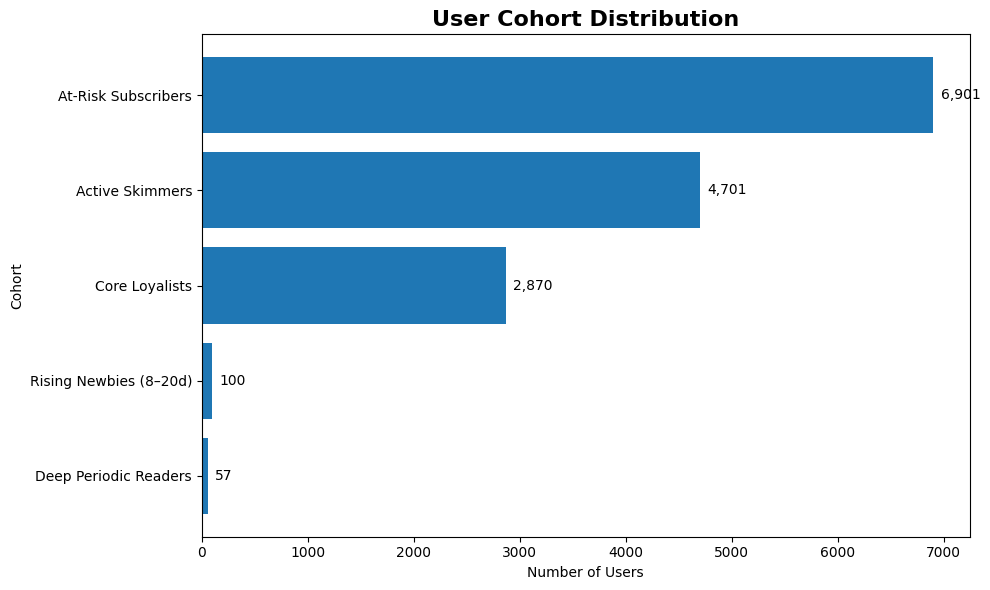

In [26]:
# === Cohort distribution bar chart ===
import matplotlib.pyplot as plt
import seaborn as sns  # optional for better style, if available

# Count users per cohort
cohort_counts = summary["Cohort"].value_counts().sort_values(ascending=True)

# Figure setup
plt.figure(figsize=(10,6))
bars = plt.barh(cohort_counts.index, cohort_counts.values)

plt.title("User Cohort Distribution", fontsize=16, weight="bold")
plt.xlabel("Number of Users")
plt.ylabel("Cohort")

# Add value labels next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + (cohort_counts.max() * 0.01),
             bar.get_y() + bar.get_height()/2,
             f"{int(width):,}", va='center')

plt.tight_layout()
plt.show()


# D. Monitor Weekly Changes

In [ ]:
# === Temperature: last week vs prior (missing => 0), Cadence-weighted composite ===
import numpy as np
import pandas as pd
from IPython.display import display
from datetime import date

# ---------- CONFIG ----------
LOOKBACK_WEEKS      = 1     # set to 1 or 2
CADENCE_WEIGHT      = 0.75  # cadence importance in composite (engagement weight = 1 - this)
DELTA_UP            = 0.08  # TempBase delta >= => Heating Up
DELTA_DOWN          = -0.08 # TempBase delta <= => Cooling Down
VIS_UP              = 1     # Visits delta >= => Up
VIS_DOWN            = -1    # Visits delta <= => Down
DO_DORMANCY_FLAGS   = True  # set False if you don't want reactivation flags
DORMANT_WEEKS       = 4     # gap (in week steps) to call a user "dormant"

# Cadence label -> numeric score (tune if needed)
CADENCE_SCORE = {
    "Daily Visitor":      1.00,
    "Weekly Visitor":     0.75,
    "Biweekly Visitor":   0.55,
    "Sporadic Visitor":   0.25,
    "Binge Visitor":      0.30,
    "One-Time Visitor":   0.10,
    "Inactive":           0.00,
    "No Cadence Data":    0.00,
    # If New Accounts overrides appear as cadence labels:
    "Fresh Joiners <7d":      0.40,
    "Rising Newbies 8d-20d":  0.45,
    "New":                    0.40,
}

# ---------- 1) Base table ----------
need_cols = ["UserId","Week","EngagementScore","Visits"]
for c in need_cols:
    if c not in eng_df.columns:
        raise KeyError(f"eng_df missing required column: {c}")

wk = pd.to_datetime(eng_df["Week"], errors="coerce")
df = eng_df.assign(_WeekSort=wk)

# Bring cadence labels from your cadence cell
if 'cadence_only' in globals():
    df = df.merge(
        cadence_only[["UserId","Week","CadenceLabel"]],
        on=["UserId","Week"], how="left"
    )
else:
    df["CadenceLabel"] = np.nan

# Aggregate in case of duplicates per (UserId, Week)
agg = (df.groupby(["UserId","Week"], as_index=False)
         .agg({"EngagementScore":"mean",
               "Visits":"sum",
               "CadenceLabel":"first",
               "_WeekSort":"max"}))

# Map cadence to numeric & build composite (Cadence heavier than Engagement)
agg["CadenceScore"] = agg["CadenceLabel"].map(CADENCE_SCORE).fillna(0.0)
agg["TempBase"] = (CADENCE_WEIGHT * agg["CadenceScore"].astype(float) +
                   (1.0 - CADENCE_WEIGHT) * agg["EngagementScore"].astype(float))

# ---------- 2) Identify weeks ----------
weeks_sorted = (agg.dropna(subset=["_WeekSort"])
                  .sort_values("_WeekSort")["_WeekSort"]
                  .drop_duplicates().tolist())
if len(weeks_sorted) < (LOOKBACK_WEEKS + 1):
    raise ValueError(f"Not enough weeks to compare with LOOKBACK_WEEKS={LOOKBACK_WEEKS}.")

wk_cur  = weeks_sorted[-1]
wk_prev = weeks_sorted[-(LOOKBACK_WEEKS+1)]

cur = agg[agg["_WeekSort"] == wk_cur].copy()
prv = agg[agg["_WeekSort"] == wk_prev].copy()

# ---------- 3) FULL OUTER JOIN (missing = 0 activity) ----------
m = cur.merge(prv, on="UserId", how="outer", suffixes=("_Wcur","_Wprev"))

# --- Create safe, object-typed display labels for week (avoid int/date dtype clashes) ---
def _representative_week_label(df_week, fallback):
    # If original "Week" exists (int like 8, or string like '2025-W08'), prefer its mode; else fallback to Timestamp
    if "Week" in df_week.columns:
        s = df_week["Week"].dropna()
        if not s.empty:
            try:
                return s.mode().iloc[0]
            except Exception:
                return s.iloc[0]
    return fallback.date() if hasattr(fallback, "date") else fallback

week_label_cur  = _representative_week_label(cur, wk_cur)
week_label_prev = _representative_week_label(prv, wk_prev)

m["WeekLabel_Wcur"]  = m.get("Week_Wcur")
m["WeekLabel_Wprev"] = m.get("Week_Wprev")
m["WeekLabel_Wcur"]  = m["WeekLabel_Wcur"].astype("object")
m["WeekLabel_Wprev"] = m["WeekLabel_Wprev"].astype("object")
m["WeekLabel_Wcur"]  = m["WeekLabel_Wcur"].where(m.get("Week_Wcur").notna(),  week_label_cur)
m["WeekLabel_Wprev"] = m["WeekLabel_Wprev"].where(m.get("Week_Wprev").notna(), week_label_prev)

# For metrics: missing => 0 (so missing in current week = going down)
for col in ["Visits_Wcur","Visits_Wprev","EngagementScore_Wcur","EngagementScore_Wprev","TempBase_Wcur","TempBase_Wprev"]:
    if col in m.columns:
        m[col] = m[col].fillna(0.0)

# Cadence: missing => "Inactive" (score 0)
for col in ["CadenceLabel_Wcur","CadenceLabel_Wprev"]:
    if col in m.columns:
        m[col] = m[col].fillna("Inactive")

# ---------- 4) Deltas & trends ----------
m["Visits_delta"]     = m["Visits_Wcur"] - m["Visits_Wprev"]
m["Engagement_delta"] = m["EngagementScore_Wcur"] - m["EngagementScore_Wprev"]
m["TempBase_delta"]   = m["TempBase_Wcur"] - m["TempBase_Wprev"]

def temp_label(d):
    if pd.isna(d): return "No Temp"
    if d >= DELTA_UP:   return "Heating Up"
    if d <= DELTA_DOWN: return "Cooling Down"
    return "Steady"

m["Temperature"] = m["TempBase_delta"].map(temp_label)

m["Visits_trend"] = np.where(m["Visits_delta"] >= VIS_UP, "Up",
                        np.where(m["Visits_delta"] <= VIS_DOWN, "Down", "Flat"))
m["Engagement_trend"] = np.where(m["Engagement_delta"] >= 0.05, "Up",
                            np.where(m["Engagement_delta"] <= -0.05, "Down", "Flat"))

# ---------- 5) (Optional) Dormant & re-appeared flags ----------
if DO_DORMANCY_FLAGS:
    # Build positional map for week steps
    pos = {w:i for i, w in enumerate(weeks_sorted)}
    cur_pos = pos[wk_cur]

    # last time seen strictly before current week
    last_seen = (agg[agg["_WeekSort"] < wk_cur]
                 .groupby("UserId")["_WeekSort"]
                 .max())

    # present now?
    present_now = set(agg.loc[agg["_WeekSort"] == wk_cur, "UserId"])
    seen_ever_before = set(last_seen.index)

    # gap in week steps
    gap_weeks = last_seen.map(lambda w: cur_pos - pos[w])

    flags = pd.DataFrame({"UserId": list(present_now)})
    flags = flags.merge(last_seen.rename("LastSeenWeek"), left_on="UserId", right_index=True, how="left")
    flags["DormantGapWeeks"] = flags["LastSeenWeek"].map(lambda w: (cur_pos - pos[w]) if pd.notna(w) else np.nan)
    flags["AppearedThisWeek"] = ~flags["UserId"].isin(seen_ever_before)
    flags["ReactivatedAfterDormancy"] = (~flags["AppearedThisWeek"]) & (flags["DormantGapWeeks"] >= DORMANT_WEEKS)

    m = m.merge(flags[["UserId","AppearedThisWeek","ReactivatedAfterDormancy","DormantGapWeeks"]],
                on="UserId", how="left").fillna({"AppearedThisWeek": False,
                                                 "ReactivatedAfterDormancy": False})

# ---------- 6) Output ----------
cols = [
    "UserId",
    "WeekLabel_Wprev","WeekLabel_Wcur",           # display-safe labels
    "CadenceLabel_Wprev","CadenceLabel_Wcur",
    "Visits_Wprev","Visits_Wcur","Visits_delta","Visits_trend",
    "EngagementScore_Wprev","EngagementScore_Wcur","Engagement_delta","Engagement_trend",
    "TempBase_Wprev","TempBase_Wcur","TempBase_delta","Temperature"
]
if DO_DORMANCY_FLAGS:
    cols += ["AppearedThisWeek","ReactivatedAfterDormancy","DormantGapWeeks"]

temp_tidy = m[cols].sort_values(["Temperature","TempBase_delta"], ascending=[True, False]).reset_index(drop=True)

display(temp_tidy.head(30))

out_path = f"/content/cleaned/temperature_{date.today().isoformat()}_lb{LOOKBACK_WEEKS}.xlsx"
temp_tidy.to_excel(out_path, index=False)
print("Saved:", out_path)


/tmp/ipython-input-3698897461.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  on="UserId", how="left").fillna({"AppearedThisWeek": False,


,UserId,WeekLabel_Wprev,WeekLabel_Wcur,CadenceLabel_Wprev,CadenceLabel_Wcur,Visits_Wprev,Visits_Wcur,Visits_delta,Visits_trend,EngagementScore_Wprev,EngagementScore_Wcur,Engagement_delta,Engagement_trend,TempBase_Wprev,TempBase_Wcur,TempBase_delta,Temperature,AppearedThisWeek,ReactivatedAfterDormancy,DormantGapWeeks
0,8830,7,8,Daily Visitor,Daily Visitor,18,9,-9,Down,0.887167,0.565799,-0.321368,Down,0.971792,0.891450,-0.080342,Cooling Down,False,False,1.0
1,528041,7,8,Daily Visitor,Daily Visitor,5,9,4,Up,0.629676,0.308281,-0.321395,Down,0.907419,0.827070,-0.080349,Cooling Down,False,False,1.0
2,28875,7,8,Daily Visitor,Daily Visitor,4,12,8,Up,0.677419,0.35564,-0.321779,Down,0.919355,0.838910,-0.080445,Cooling Down,False,False,1.0
3,459697,7,8,Weekly Visitor,Weekly Visitor,2,1,-1,Down,0.476708,0.154579,-0.32213,Down,0.681677,0.601145,-0.080532,Cooling Down,False,False,1.0
4,459753,7,8,One-Time Visitor,Inactive,1,0,-1,Down,0.02235,0.0,-0.02235,Flat,0.080587,0.000000,-0.080587,Cooling Down,False,False,NaN
5,493254,7,8,Weekly Visitor,Weekly Visitor,2,1,-1,Down,0.540613,0.216577,-0.324036,Down,0.697653,0.616644,-0.081009,Cooling Down,False,False,1.0
6,495178,7,8,Weekly Visitor,Weekly Visitor,2,5,3,Up,0.462166,0.137727,-0.324439,Down,0.678042,0.596932,-0.081110,Cooling Down,False,False,1.0
7,544310,7,8,Daily Visitor,Daily Visitor,10,8,-2,Down,0.534969,0.21008,-0.32489,Down,0.883742,0.802520,-0.081222,Cooling Down,False,False,1.0
8,464096,7,8,Weekly Visitor,Weekly Visitor,1,4,3,Up,0.496974,0.171755,-0.325219,Down,0.686744,0.605439,-0.081305,Cooling Down,False,False,1.0
9,478493,7,8,One-Time Visitor,One-Time Visitor,1,1,0,Flat,0.640999,0.315578,-0.325421,Down,0.235250,0.153894,-0.081355,Cooling Down,False,False,1.0


Saved: /content/cleaned/temperature_2025-10-06_lb1.xlsx


Make it look back 2 weeks to see temp

In [ ]:
# === Segmentation snapshot (join-only; copy subscription column as-is but look back 2 weeks) ===
import pandas as pd
import re
from IPython.display import display
from datetime import date

# ---------- helpers ----------
def _norm_name(s):
    if s is None: return ""
    s = str(s).replace("\u00A0"," ")
    s = re.sub(r"\s+"," ", s).strip().lower()
    return s

def pick(cols, opts):
    nm = {_norm_name(c): c for c in cols}
    for o in opts:
        k = _norm_name(o)
        if k in nm: return nm[k]
    return None

# ---------- 0) Base = latest week from eng_df ----------
if "eng_df" not in globals():
    raise RuntimeError("eng_df not found.")

wk = pd.to_datetime(eng_df["Week"], errors="coerce")
weeks_sorted = wk.dropna().sort_values().drop_duplicates().tolist()
if not weeks_sorted:
    raise ValueError("No valid weeks in eng_df.")
wk_cur = weeks_sorted[-1]

base = (eng_df.assign(_WeekSort=wk)
        .loc[lambda d: d["_WeekSort"] == wk_cur]
        .groupby("UserId", as_index=False)
        .agg({"Week":"first"}))

seg = base.copy()

# ---------- 1) Join from merged: New Accounts + (raw) subscription column ----------
if "merged" in globals() and isinstance(merged, pd.DataFrame):
    tmp = merged.copy()

    # New Accounts column (use whatever exists; prefer exact name)
    new_col = "New Accounts" if "New Accounts" in tmp.columns else pick(tmp.columns, ["New Accounts","New_Accounts","NewAccounts"])

    # Subscription status column — copy AS-IS (e.g., "Subscribed" with values "Subscribed"/"Not Subscribed")
    sub_col = None
    for cand in ["Subscribed","Subscription","Subscription Status","is_subscribed","IsSubscribed"]:
        c = pick(tmp.columns, [cand])
        if c:
            sub_col = c
            break

    keep = ["UserId"]
    if new_col: keep.append(new_col)
    if sub_col: keep.append(sub_col)

    dim = tmp[keep].dropna(subset=["UserId"]).drop_duplicates("UserId").copy()

    # Rename to consistent output names only if present
    rename_map = {}
    if new_col and new_col != "New Accounts": rename_map[new_col] = "New Accounts"
    if sub_col and sub_col != "Subscribed":   rename_map[sub_col] = "Subscribed"
    if rename_map:
        dim = dim.rename(columns=rename_map)

    seg = seg.merge(dim[[c for c in ["UserId","New Accounts","Subscribed"] if c in dim.columns]],
                    on="UserId", how="left")

# ---------- 2) Join CadenceLabel from cadence_only (latest week) ----------
if "cadence_only" in globals() and isinstance(cadence_only, pd.DataFrame):
    wc = pd.to_datetime(cadence_only["Week"], errors="coerce") if "Week" in cadence_only.columns else wk
    cad_latest = (cadence_only.assign(_WeekSort=wc)
                  .loc[lambda d: d["_WeekSort"] == wk_cur]
                  .groupby("UserId", as_index=False)
                  .agg({"CadenceLabel":"first"}))
    seg = seg.merge(cad_latest, on="UserId", how="left")

# ---------- 3) Join DepthBand (engagement label) from dfb (latest week) ----------
if "dfb" in globals() and isinstance(dfb, pd.DataFrame) and "DepthBand" in dfb.columns:
    wb = pd.to_datetime(dfb["Week"], errors="coerce") if "Week" in dfb.columns else wk
    depth_latest = (dfb.assign(_WeekSort=wb)
                    .loc[lambda d: d["_WeekSort"] == wk_cur]
                    .groupby("UserId", as_index=False)
                    .agg({"DepthBand":"first"}))
    seg = seg.merge(depth_latest, on="UserId", how="left")

# ---------- 4) Join Temperature + dormancy flags from temp_tidy (already computed) ----------
if "temp_tidy" in globals() and isinstance(temp_tidy, pd.DataFrame):
    avail = [c for c in [
        "Temperature","TempBase_delta","Engagement_delta","Visits_delta",
        "AppearedThisWeek","ReactivatedAfterDormancy","DormantGapWeeks"
    ] if c in temp_tidy.columns]
    if avail:
        tjoin = temp_tidy[["UserId"] + avail].drop_duplicates("UserId")
        seg = seg.merge(tjoin, on="UserId", how="left")

# ---------- 5) Final columns (only those that exist) ----------
want = ["UserId","Week","New Accounts","Subscribed","CadenceLabel","DepthBand",
        "Temperature","TempBase_delta","Engagement_delta","Visits_delta",
        "AppearedThisWeek","ReactivatedAfterDormancy","DormantGapWeeks"]
final_cols = [c for c in want if c in seg.columns]

segmentation_df = seg[final_cols].copy()

# Preview + Export
display(segmentation_df.head(30))
out_path = f"/content/cleaned/segmentation_snapshot_{date.today().isoformat()}.xlsx"
segmentation_df.to_excel(out_path, index=False)
print("Saved:", out_path)


,UserId,Week,New Accounts,Subscribed,CadenceLabel,DepthBand,Temperature,TempBase_delta,Engagement_delta,Visits_delta,AppearedThisWeek,ReactivatedAfterDormancy,DormantGapWeeks
0,0,8,Old,Not Subscribed,Daily Visitor,Light Depth,Heating Up,0.247555,-0.359782,180,False,False,1.0
1,1,8,Old,Subscribed,Daily Visitor,Light Depth,Cooling Down,-0.088070,-0.352281,2,False,False,1.0
2,3,8,Old,Subscribed,Daily Visitor,High Depth,Steady,-0.000915,-0.003659,-3,False,False,1.0
3,39,8,Old,Not Subscribed,Binge Visitor,High Depth,Heating Up,0.462805,0.95122,2,True,False,NaN
4,40,8,Old,Not Subscribed,Binge Visitor,High Depth,Heating Up,0.382114,0.628457,4,True,False,NaN
5,41,8,Old,Not Subscribed,Binge Visitor,High Depth,Heating Up,0.388571,0.654285,15,True,False,NaN
6,170,8,Old,Subscribed,Weekly Visitor,High Depth,Steady,-0.072753,0.458988,-32,False,False,1.0
7,315,8,Old,Subscribed,Daily Visitor,High Depth,Heating Up,0.098334,0.393337,-9,False,False,1.0
8,514,8,Old,Subscribed,Daily Visitor,Good Depth,Cooling Down,-0.125279,-0.501115,8,False,False,1.0
9,778,8,Old,Subscribed,Daily Visitor,Good Depth,Steady,-0.029068,-0.116272,-3,False,False,1.0


Saved: /content/cleaned/segmentation_snapshot_2025-10-06.xlsx


# D. Output Segmented Cohorts